# Initialize Notebook

In [1]:
# Import dependencies and set basic variables
import numpy as np
import os
import h5py
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patches as patches
import matplotlib.colors as colors
import seaborn as sns
import networkx as nx
import time
import sys
from metrics.matrixSimilarity import matrixSimilarity
from connectivity.parCorrInvCov import parCorrInvCov

# Project directories
dataDir = '/projects/f_mc1689_1/ReliableFC/data'
scriptsDir = '/projects/f_mc1689_1/ReliableFC/docs/scripts'
figDir = '/projects/f_mc1689_1/ReliableFC/docs/figures'

sys.path.append(f'{scriptsDir}/connectivity')
sys.path.append(f'{scriptsDir}/plotting')
from plotMatrix_cabnpNetColors import plotMatrix_cabnpNetColors
from scaledColorMap import scaledColorMap
from plotToCortex import plotToCortex

# Subject numbers and basic info
dataset = 'discovery'
#dataset = 'replication'
subjectsFile = f'{scriptsDir}/subjects_{dataset}.tsv'
subjectsDF = pd.read_csv(subjectsFile,sep='\t',index_col='subjects')
subjList = subjectsDF.index.values
nSubjs = len(subjList)
subjAge = subjectsDF['age'].values

# Order of parcels by network
parcType = 'cortex'
parcOrderFile = f'{scriptsDir}/cabnp/{parcType}_community_order.txt'
parcOrder = pd.read_csv(parcOrderFile, sep='\t', header=None)[0] - 1
parcOrderReverse = parcOrder.sort_values().index
nNodes = len(parcOrder)
nEdges = ((nNodes**2) - nNodes)//2

# For figures
plt.rcParams.update({'font.size': 7})
from pathlib import Path
import matplotlib as mpl
from matplotlib import font_manager as fm
font_file = Path(mpl.get_data_path(),f'{scriptsDir}/plotting/arial/arial.ttf')
fm.fontManager.addfont(font_file)
font_file = Path(mpl.get_data_path(),f'{scriptsDir}/plotting/arial/arialbd.ttf')
fm.fontManager.addfont(font_file)
plt.rcParams.update({'font.family': 'arial'})

print(dataset,'---')
print('Subjects:\t',nSubjs)
print('Nodes:\t\t',nNodes)
print(f'Ages:\t\t{np.amin(subjAge)}-{np.amax(subjAge)}, mean = {np.mean(subjAge)}, SD = {np.std(subjAge)}')

pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


discovery ---
Subjects:	 236
Nodes:		 360
Ages:		36.0833-89.0833, mean = 56.88841737288136, SD = 13.947262425557486


In [2]:
def formatTStat(t):
    if abs(t)>=100: tStr = f'{t:03.0f}'
    elif abs(t)>=10: tStr = f'{t:02.1f}'
    elif abs(t)>=1: tStr = f'{t:01.2f}'
    else: tStr = f'{t:00.3f}'
    return tStr

def formatPVal(p):
    if p<.00001: pStr = '< .00001'
    else:
        if p<.0001: pStr = f'{p:.5f}'
        elif p<.001: pStr = f'{p:.4f}'
        else: pStr = f'{p:.3f}'
        pStr = f'= {pStr[1:]}'
    return pStr

def correlatedCorrelations(r_x1y,r_x2y,r_x1x2,N):
    z_x1y = np.arctanh(r_x1y)
    z_x2y = np.arctanh(r_x2y)
    
    meanr2_x = (r_x1y**2 + r_x2y**2)/2
    f = (1-r_x1x2)/(2*(1-meanr2_x))
    if f > 1:
        f = 1
    h = (1-f*meanr2_x)/(1-meanr2_x)
    
    Z = (z_x1y-z_x2y)*((N-3)/(2*(1-r_x1x2)*h))**.5
    pval = stats.norm.sf(abs(Z))*2 #(2-tailed)
    
    return Z,pval
    

In [3]:
methodsList = ['pairwiseCorr','partialCorr','graphicalLasso','graphicalRidge','pcRegression']

paramsFull = {}
paramsFull['pairwiseCorr'] = None
paramsFull['partialCorr'] = None
paramsFull['graphicalLasso'] = np.round(np.hstack([np.arange(0,.005,.001),np.arange(.005,.205,.005)]),3)
paramsFull['graphicalRidge'] = np.round(np.hstack([np.arange(0,.1,.02),np.arange(.1,3.1,.1)]),3)
paramsFull['pcRegression'] = np.round(np.hstack([[1,5,10,15],np.arange(20,361,10)]),3)
paramsFull['pcRegression'][-1] = 359

# Compute FC Matrices

In [ ]:
# Compute FC for regularized methods (parallel jobs)
for method in ['graphicalLasso']:#,'graphicalRidge','pcRegression']:
    for s,subj in enumerate(subjList[:]):
        print(subj)
        os.system(f'{scriptsDir}/connectivity/empFC_batch.sh {subj} {method}')

graphicalLasso optimal hyperparameters (R^2): mean = 0.034 (SD = 0.006)
graphicalRidge optimal hyperparameters (R^2): mean = 0.404 (SD = 0.154)
pcRegression optimal hyperparameters (R^2): mean = 54.566 (SD = 14.850)


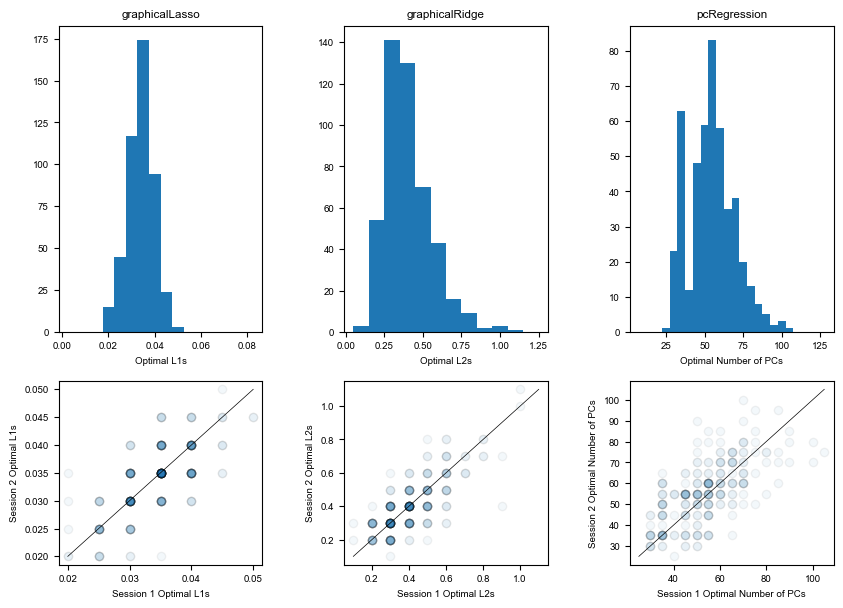

In [4]:
# Show summaries of optimal hyperparameters 
paramsOpt = {}
paramsOpt['graphicalLasso'] = np.round(np.arange(.005,.085,.005),3)
paramsOpt['graphicalRidge'] = np.round(np.arange(0.1,1.3,.1),3)
paramsOpt['pcRegression'] = np.round(np.arange(10,130,5),3)

bestParams = {}
fig,axs = plt.subplots(2, 3, figsize=(10,7),gridspec_kw={'hspace':.2,'wspace':.4,'height_ratios':[1,.6]})
paramNames = ['L1s','L2s','Number of PCs']
for m,method in enumerate(['graphicalLasso','graphicalRidge','pcRegression']):
    bestParams[method] = np.full((nSubjs,2),np.nan)
    for se,ses in enumerate(['1','2']):
        for s,subj in enumerate(subjList[:]):
            bestParams[method][s,se] = np.load(f'{dataDir}/empirical/connectivity/{method}/{subj}_ses-{ses}/bestParam.npy')
    
    print(f'{method} optimal hyperparameters (R^2): mean = {np.mean(bestParams[method]):.3f} (SD = {np.std(bestParams[method]):.3f})')
    
    bins = np.append(paramsOpt[method],paramsOpt[method][-1]+(paramsOpt[method][1]-paramsOpt[method][0]))
    bins = bins - (bins[1]-bins[0])/2
    axs[0,m].hist(bestParams[method].flatten(),bins=bins)
    axs[0,m].set_title(method)
    axs[0,m].set_xlabel(f'Optimal {paramNames[m]}')
    
    axs[1,m].scatter(bestParams[method][:,0],bestParams[method][:,1],alpha=.05,edgecolor='k')
    axs[1,m].set_xlabel(f'Session 1 Optimal {paramNames[m]}')
    axs[1,m].set_ylabel(f'Session 2 Optimal {paramNames[m]}')
    axs[1,m].plot([np.amin(bestParams[method].flatten()),np.amax(bestParams[method].flatten())],[np.amin(bestParams[method].flatten()),np.amax(bestParams[method].flatten())],'k',linewidth=.5)
    
    

In [ ]:
# Compute and save pairwise and partial correlation FC estimates
# (or use next block)
from connectivity.empFC_wrapper import empFC_wrapper
#method = 'pairwiseCorr'
method = 'partialCorr'
for s,subj in enumerate(subjList): 
    print(s,subj)
    empFC_wrapper(subj,method)

In [ ]:
# Compute and save pairwise and partial correlation FC estimates
from getRestData import getRestData
from connectivity.parCorrInvCov import parCorrInvCov

FC = {}
for method in ['pairwiseCorr','partialCorr']:
    FC[method] = {}
    for ses in ['1','2']:
        FC[method][ses] = np.full((nNodes,nNodes,nSubjs),np.nan)
        
for s,subj in enumerate(subjList):
    print(s)
    restData = getRestData(subj)
    restData = restData[parcOrder]
    
    for ses in ['1','2']:
        sesTimepoints = np.load(f'{dataDir}/empirical/connectivity/ses-{ses}_timepoints.npy')
        data = restData[:,sesTimepoints].copy()
        data = stats.zscore(data,axis=1)
        
        # Run pairwise correlation
        FC['pairwiseCorr'][ses][:,:,s] = np.corrcoef(data)
        np.fill_diagonal(FC['pairwiseCorr'][ses][:,:,s],0)
        
        # Run partial correlation
        FC['partialCorr'][ses][:,:,s],prec = parCorrInvCov(data.T)
        
for method in ['pairwiseCorr','partialCorr']:
    connFileFinal = f'{dataDir}/empirical/connectivity/{method}_{dataset}.h5'
    with h5py.File(connFileFinal,'a') as h5File:
        for ses in ['1','2']:
            try:
                h5File.create_dataset(f'ses-{ses}',data=FC[method][ses])
            except:
                del h5File[f'ses-{ses}']
                h5File.create_dataset(f'ses-{ses}',data=FC[method][ses])
                

## Aggregate FC Matrices

In [ ]:
# Aggregate FC matrices from regularized methods
# Save an .h5 file for each method with all subjects' data 
path = f'{dataDir}/empirical'

for method in ['pairwiseCorr','partialCorr','graphicalLasso','graphicalRidge','pcRegression']:
    print(method)
    connFileFinal = f'{path}/connectivity/{method}_{dataset}.h5'
    with h5py.File(connFileFinal,'a') as h5File:
        for ses in ['1','2']:
            connOpt = np.full((nNodes,nNodes,nSubjs),np.nan)
            paramsOpt = np.full((nSubjs),np.nan)
            if (paramsFull[method] is None):
                for s,subj in enumerate(subjList):
                    connFileSubjOpt = f'{path}/connectivity/{method}/{subj}_ses-{ses}/{method}.npy'
                    connOpt[:,:,s] = np.load(connFileSubjOpt)
                    np.fill_diagonal(connOpt[:,:,s],0)
                    connOpt[:,:,s] = (connOpt[:,:,s]+connOpt[:,:,s].T)/2
                try:
                    h5File.create_dataset(f'ses-{ses}/FC',data=connOpt)
                except:
                    del h5File[f'ses-{ses}/FC']
                    h5File.create_dataset(f'ses-{ses}/FC',data=connOpt)
            
            else:
                for s,subj in enumerate(subjList):
                    connFileSubjOpt = f'{path}/connectivity/{method}/{subj}_ses-{ses}/{method}_opt-R2.npy'
                    connOpt[:,:,s] = np.load(connFileSubjOpt)
                    paramFileSubjOpt = f'{path}/connectivity/{method}/{subj}_ses-{ses}/bestParam.npy'
                    paramsOpt[s] = np.load(paramFileSubjOpt)
                    np.fill_diagonal(connOpt[:,:,s],0)
                    connOpt[:,:,s] = (connOpt[:,:,s]+connOpt[:,:,s].T)/2
                try:
                    h5File.create_dataset(f'ses-{ses}/FC',data=connOpt)
                except:
                    del h5File[f'ses-{ses}/FC']
                    h5File.create_dataset(f'ses-{ses}/FC',data=connOpt)
                try:
                    h5File.create_dataset(f'ses-{ses}/bestParams',data=paramsOpt)
                except:
                    del h5File[f'ses-{ses}/bestParams']
                    h5File.create_dataset(f'ses-{ses}/bestParams',data=paramsOpt)
                    
                for param in paramsFull[method]:
                    print(param)
                    connParam = np.full((nNodes,nNodes,nSubjs),np.nan)
                    for s,subj in enumerate(subjList):
                        connFileSubjParam = f'{path}/connectivity/{method}/{subj}_ses-{ses}/FC_param-{param}.npy'
                        connParam[:,:,s] = np.load(connFileSubjParam)
                        np.fill_diagonal(connParam[:,:,s],0)
                        connParam[:,:,s] = (connParam[:,:,s]+connParam[:,:,s].T)/2
                    try:
                        h5File.create_dataset(f'ses-{ses}/param-{param}/FC',data=connParam)
                    except:
                        del h5File[f'ses-{ses}/param-{param}/FC']
                        h5File.create_dataset(f'ses-{ses}/param-{param}/FC',data=connParam)
        

# Load FC Matrices

In [5]:
FC = {}
FCByParam = {}
for method in methodsList:
    FC[method] = {}
    FCByParam[method] = {}
    connFileFinal = f'{dataDir}/empirical/connectivity/{method}_{dataset}.h5'
    with h5py.File(connFileFinal,'r') as h5File:
        for ses in ['1','2']:
            FC[method][ses] = h5File[f'ses-{ses}/FC'][:]
            if not (paramsFull[method] is None):
                FCByParam[method][ses] = np.full((nNodes,nNodes,nSubjs,len(paramsFull[method])),np.nan)
                for p,param in enumerate(paramsFull[method]):
                    ##print(method,param)
                    FCByParam[method][ses][:,:,:,p] = h5File[f'ses-{ses}/param-{param}/FC'][:]
            else:
                FCByParam[method][ses] = None


# Visualize FC Matrices

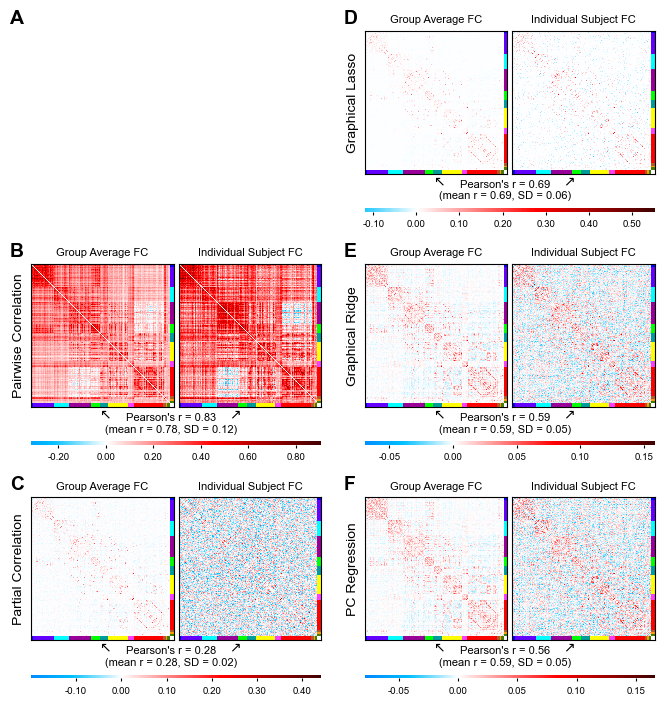

In [6]:
ses = '1'
methodsPrintedLabels = ['Pairwise Correlation','Partial Correlation','Graphical Lasso','Graphical Ridge','PC Regression']
letters = ['B','C','D','E','F']

fig,axs = plt.subplots(9, 2, figsize=(6.5,7),gridspec_kw={'hspace':.15,'wspace':.15,'width_ratios':[1,1],'height_ratios':[1,.02,.04,1,.02,.04,1,.02,.04]})
fig.subplots_adjust(left=0.035,right=0.995,top=.995,bottom=.01)

for row in range(9):
    for col in range(2):
        axs[row,col].set_xticks([]); axs[row,col].set_yticks([])

for m,(row,col) in enumerate([(3,0),(6,0),(0,1),(3,1),(6,1)]):
    method = methodsList[m]    
    axs[row,col].set_ylabel(methodsPrintedLabels[m],size=10)#,font=arialpath)
    axs[row+2,col].remove()
    divider = make_axes_locatable(axs[row,col])
    ax2 = divider.append_axes("right", size="100%", pad=0.05)
    ax2.set_xticks([]); ax2.set_yticks([])

    FCavg = np.mean(FC[method][ses],axis=2)
    vmin = np.amin([FCavg,FC[method][ses][:,:,0]])
    vmax = np.amax([FCavg,FC[method][ses][:,:,0]])
    axs[row,col],im = plotMatrix_cabnpNetColors(axs[row,col],FCavg,positions=['right','bottom'],buffer=10,vmin=vmin,vmax=vmax)
    ax2,im = plotMatrix_cabnpNetColors(ax2,FC[method][ses][:,:,0],positions=['right','bottom'],buffer=10,vmin=vmin,vmax=vmax)
    cb = plt.colorbar(im,cax=axs[row+1,col],format="%0.2f",orientation='horizontal')
    clabels = axs[row+1,col].get_yticklabels()
    axs[row+1,col].set_yticklabels(clabels,fontsize=7)
    axs[row+1,col].tick_params(axis='x',length=2)
    cb.outline.set_visible(False)
    
    #if (m==0) or (m==2):
    axs[row,col].set_title('Group Average FC',fontsize=8)
    ax2.set_title('Individual Subject FC',fontsize=8)
    
    axs[row,col].text(-55,-20,letters[m],fontsize=14,ha='left',weight='bold')
    indivToGroupSim = matrixSimilarity(FC[method][ses],np.repeat(FCavg[:,:,np.newaxis],nSubjs,axis=2))
    simMean = np.tanh(np.mean(np.arctanh(indivToGroupSim)))
    simSD = np.tanh(np.std(np.arctanh(indivToGroupSim)))
    axs[row,col].text(364,435,f"Pearson's r = {indivToGroupSim[0]:.2f}\n(mean r = {simMean:.2f}, SD = {simSD:.2f})",fontsize=8,ha='center')
    axs[row,col].text(364-155,400,r'$\nwarrow$',fontsize=10,ha='right')
    axs[row,col].text(364+145,400,r'$\nearrow$',fontsize=10,ha='left')

axs[1,0].remove(); axs[2,0].remove()
divider = make_axes_locatable(axs[0,0])
ax2 = divider.append_axes("right", size="100%", pad=0.05)
ax2.remove()
axs[0,0].imshow(np.full((nNodes+10,nNodes+10),np.nan))
axs[0,0].spines.left.set_visible(False); axs[0,0].spines.right.set_visible(False)
axs[0,0].spines.top.set_visible(False); axs[0,0].spines.bottom.set_visible(False)
axs[0,0].text(-55,-20,'A',fontsize=14,ha='left',weight='bold')
    
fig.savefig(f'{figDir}/fig2.pdf',dpi=900,transparent=True)

# Test Reliability

In [7]:
from metrics.matrixSimilarity import matrixSimilarity
from metrics.intraclassCorrelationCoefficient import intraclassCorrelationCoefficient

# Select highly weighted edges that ICC will be limited to
PCT_THRESH = 98
highEdgesByMethod = np.full((nEdges,len(methodsList)),False)
for m,method in enumerate(methodsList):
    
    FCVecSes12 = np.dstack([FC[method]['1'][np.triu_indices(nNodes,k=1)][:,:,np.newaxis],FC[method]['2'][np.triu_indices(nNodes,k=1)][:,:,np.newaxis]])
    meanFCVecSes12 = np.mean(FCVecSes12,axis=(1,2))
    highEdgesByMethod[:,m] = meanFCVecSes12 >= np.percentile(meanFCVecSes12,PCT_THRESH)

highEdges = np.sum(highEdgesByMethod,axis=1) == len(methodsList)
print(highEdges.shape,np.sum(highEdges))

# Calculate between-session similarity and ICC
sesSimDF = pd.DataFrame(data={'Method':[],'Data':[]})
sesSimByParam = {}
iccDF = pd.DataFrame(data={'Method':[],'Data':[]})
iccByParam = {}
for m,method in enumerate(methodsList):
    #print(method)
    tmpDF = pd.DataFrame(data={'Method':[],'Data':[]})
    tmpDF['Data'] = matrixSimilarity(FC[method]['1'],FC[method]['2'])
    tmpDF['Method'] = method
    sesSimDF = pd.concat([sesSimDF,tmpDF])
    
    tmpDF = pd.DataFrame(data={'Method':[],'Data':[]})
    FCVecSes12 = np.dstack([FC[method]['1'][np.triu_indices(nNodes,k=1)][:,:,np.newaxis],FC[method]['2'][np.triu_indices(nNodes,k=1)][:,:,np.newaxis]])
    tmpDF['Data'] = intraclassCorrelationCoefficient(FCVecSes12[highEdges])
    tmpDF['Method'] = method
    iccDF = pd.concat([iccDF,tmpDF])
    
    if not (paramsFull[method] is None):
        sesSimByParam[method] = np.full((nSubjs,len(paramsFull[method])),np.nan)
        iccByParam[method] = np.full((np.sum(highEdges),len(paramsFull[method])),np.nan)
        for p,param in enumerate(paramsFull[method]):
            #print(method,p)
            sesSimByParam[method][:,p] = matrixSimilarity(FCByParam[method]['1'][:,:,:,p],FCByParam[method]['2'][:,:,:,p])
    
            FCVecSes12ByParam = np.dstack([FCByParam[method]['1'][np.triu_indices(nNodes,k=1)][:,:,np.newaxis,p],FCByParam[method]['2'][np.triu_indices(nNodes,k=1)][:,:,np.newaxis,p]])
            iccByParam[method][:,p] = intraclassCorrelationCoefficient(FCVecSes12ByParam[highEdges])
      
    print(f'{method}')
    print(f'\tbetween-session similarity: mean r = {np.mean(sesSimDF.loc[sesSimDF["Method"]==method,"Data"]):.3f}, SD = {np.std(sesSimDF.loc[sesSimDF["Method"]==method,"Data"]):.3f}')
    print(f'\tintraclass correlation: mean ICC = {np.mean(iccDF.loc[iccDF["Method"]==method,"Data"]):.3f}, SD = {np.std(iccDF.loc[iccDF["Method"]==method,"Data"]):.3f}')


(64620,) 543
pairwiseCorr
	between-session similarity: mean r = 0.804, SD = 0.058
	intraclass correlation: mean ICC = 0.670, SD = 0.053
partialCorr
	between-session similarity: mean r = 0.108, SD = 0.015
	intraclass correlation: mean ICC = 0.310, SD = 0.115
graphicalLasso
	between-session similarity: mean r = 0.642, SD = 0.048
	intraclass correlation: mean ICC = 0.603, SD = 0.096
graphicalRidge
	between-session similarity: mean r = 0.480, SD = 0.036
	intraclass correlation: mean ICC = 0.619, SD = 0.077
pcRegression
	between-session similarity: mean r = 0.494, SD = 0.040
	intraclass correlation: mean ICC = 0.592, SD = 0.074


In [8]:
methodsPrintedLabels = ['Pairwise Correlation','Partial Correlation','Graphical Lasso','Graphical Ridge','PC Regression']
colNames = [(' ','Methods'),(' ',"Between-Session Similarity (Pearson's r)"),(' ',"Intraclass Correlation (ICC)"),("Structural-Functional Similarity (Pearson's r)","Group-Averaged"),("Structural-Functional Similarity (Pearson's r)","Individual")]

if dataset == 'discovery':
    tableFilename = f'{figDir}/table1.tsv'
if dataset == 'replication':
    tableFilename = f'{figDir}/tableS1.tsv'
    
if os.path.exists(tableFilename):
    tableDF = pd.read_csv(tableFilename,sep='\t',index_col=0,header=[0,1])
else:
    tableDF = pd.DataFrame(columns=pd.MultiIndex.from_tuples(colNames, names=["line1", "line2"]))

i = 1
for m1,method1 in enumerate(methodsList):
    for m2,method2 in enumerate(methodsList):
        if m2 <= m1:
            continue
        tableDF.loc[i,(' ','Methods')] = f'{methodsPrintedLabels[m1]} vs. {methodsPrintedLabels[m2]}'
        
        diff = np.tanh(np.mean(np.arctanh(sesSimDF.loc[sesSimDF['Method']==method1,'Data'])-np.arctanh(sesSimDF.loc[sesSimDF['Method']==method2,'Data'])))
        [t,p] = stats.ttest_rel(np.arctanh(sesSimDF.loc[sesSimDF['Method']==method1,'Data']),np.arctanh(sesSimDF.loc[sesSimDF['Method']==method2,'Data']))
        tableStr = f'mean ∆r = {diff:.3f}, T({nSubjs-1}) = {formatTStat(t)}, p {formatPVal(p)}'
        tableDF.loc[i,(" ","Between-Session Similarity (Pearson's r)")] = tableStr
        
        diff = np.mean(iccDF.loc[iccDF['Method']==method1,'Data']-iccDF.loc[iccDF['Method']==method2,'Data'])
        [t,p] = stats.ttest_rel(iccDF.loc[iccDF['Method']==method1,'Data'],iccDF.loc[iccDF['Method']==method2,'Data'])
        tableStr = f'mean ∆ICC = {diff:.3f}, T({np.sum(highEdges)-1}) = {formatTStat(t)}, p {formatPVal(p)}'
        tableDF.loc[i,(" ","Intraclass Correlation (ICC)")] = tableStr
        i+=1
        
print(tableDF)
tableDF.to_csv(tableFilename,sep='\t')

line1                                                \
line2                                       Methods   
1      Pairwise Correlation vs. Partial Correlation   
2          Pairwise Correlation vs. Graphical Lasso   
3          Pairwise Correlation vs. Graphical Ridge   
4            Pairwise Correlation vs. PC Regression   
5           Partial Correlation vs. Graphical Lasso   
6           Partial Correlation vs. Graphical Ridge   
7             Partial Correlation vs. PC Regression   
8               Graphical Lasso vs. Graphical Ridge   
9                 Graphical Lasso vs. PC Regression   
10                Graphical Ridge vs. PC Regression   

line1                                                \
line2      Between-Session Similarity (Pearson's r)   
1         mean ∆r = 0.770, T(235) = 100, p < .00001   
2        mean ∆r = 0.350, T(235) = 39.1, p < .00001   
3        mean ∆r = 0.541, T(235) = 65.0, p < .00001   
4        mean ∆r = 0.528, T(235) = 62.4, p < .00001   
5       m

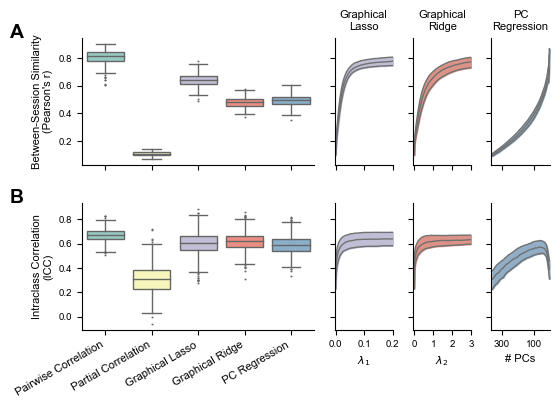

In [9]:
fig,axs = plt.subplots(2,4,figsize=(5.5,4),sharex='col',sharey='row',gridspec_kw={'hspace':.3,'wspace':.2,'width_ratios':[4,1,1,1]})
fig.subplots_adjust(left=.14,right=0.99,top=.91,bottom=.18)

# Colors for graph lasso, graph ridge, and pc regress param plots
colors_ = [[.753,.745,.835],[.867,.573,.529],[.573,.682,.776]]
grey = [.439,.443,.439]

methodsPrintedLabels = ['Pairwise Correlation','Partial Correlation','Graphical Lasso','Graphical Ridge','PC Regression']

# Loop through metrics (rows)
for n in range(2):
    if n==0: 
        boxData = sesSimDF
        paramData = sesSimByParam
    elif n==1:
        boxData = iccDF
        paramData = iccByParam

    # Make boxplots
    sns.boxplot(x='Method',y="Data",data=boxData,palette="Set3",ax=axs[n,0],fliersize=.5,linewidth=1)

    # Make hyperparameter line plots
    for m,method in enumerate(['graphicalLasso','graphicalRidge','pcRegression']):
        
        med = np.nanmedian(paramData[method],axis=0)
        pct25 = np.nanpercentile(paramData[method],25,axis=0)
        pct75 = np.nanpercentile(paramData[method],75,axis=0)
        axs[n,m+1].fill_between(paramsFull[method],pct25,pct75,color=colors_[m],alpha=1)
        axs[n,m+1].plot(paramsFull[method],med,color=grey,linewidth=1)
        axs[n,m+1].plot(paramsFull[method],pct25,color=grey,linewidth=1)
        axs[n,m+1].plot(paramsFull[method],pct75,color=grey,linewidth=1)
        
        ylims = axs[n,0].get_ylim()
        axs[n,m+1].set_ylim(ylims)

# X-axis method labels
axs[1,0].set_xticklabels(methodsPrintedLabels, rotation=30, size=8, ha='right',ma='right',rotation_mode='default')
for a in range(2):
    axs[a,0].set_xlabel('')    

# X-axis hyperparams labels
axs[1,1].set_xlim(-.004,.2)
axs[1,2].set_xlim(-.06,3)
axs[1,3].set_xlim(365,0)

axs[1,1].set_xticks([0,.1,.2])
axs[1,2].set_xticks([0,1,2,3])
axs[1,3].set_xticks([300,100])

axs[1,1].set_xlabel('$\lambda_1$',size=8)
axs[1,2].set_xlabel('$\lambda_2$',size=8)
axs[1,3].set_xlabel('# PCs',size=8)

# Y-axis labels
axs[0,0].set_ylabel("Between-Session Similarity\n(Pearson's r)",size=8)
axs[1,0].set_ylabel("Intraclass Correlation\n(ICC)",size=8)

# Set right-panel titles
axs[0,1].set_title('Graphical\nLasso',fontsize=8)
axs[0,2].set_title('Graphical\nRidge',fontsize=8)
axs[0,3].set_title('PC\nRegression',fontsize=8)

# Remove borders   
for a1 in range(2):
    for a2 in range(4):
        axs[a1,a2].spines.right.set_visible(False)
        axs[a1,a2].spines.top.set_visible(False)

# Add figure lettering
for m,letter in enumerate(['A','B']):
    axs[m,0].text(-2.05,axs[m,0].get_ylim()[1],letter,fontsize=14,ha='left',weight='bold')

if dataset == 'discovery':
    fig.savefig(f'{figDir}/Figure3.pdf',dpi=600,transparent=True)
elif dataset == 'replication':
    fig.savefig(f'{figDir}/FigureS1.pdf',dpi=600,transparent=True)


# Structural-Functional Similarity

In [10]:
from metrics.matrixSimilarity import matrixSimilarity

SC = np.load(f'{dataDir}/empirical/connectivity/structural_cortex_{dataset}.npy')
ses = '1'

# Calculate individual and group-averaged structural-functional similarity
sfSimDF = pd.DataFrame(data={'Method':[],'Data':[]})
sfSimByParam = {}
sfSimAvgDF = pd.DataFrame(data={'Method':[],'Data':[]})
sfSimAvgByParam = {}
for m,method in enumerate(methodsList):
    #print(method)
    tmpDF = pd.DataFrame(data={'Method':[],'Data':[]})
    tmpDF['Data'] = matrixSimilarity(FC[method][ses],SC)
    tmpDF['Method'] = method
    sfSimDF = pd.concat([sfSimDF,tmpDF])
    
    tmpDF = pd.DataFrame(data={'Method':[],'Data':[]})
    tmpDF.loc[0,'Data'] = matrixSimilarity(np.mean(FC[method][ses],axis=2),np.mean(SC,axis=2))
    tmpDF.loc[0,'Method'] = method
    sfSimAvgDF = pd.concat([sfSimAvgDF,tmpDF])
    
    if not (paramsFull[method] is None):
        sfSimByParam[method] = np.full((nSubjs,len(paramsFull[method])),np.nan)
        sfSimAvgByParam[method] = np.full((len(paramsFull[method])),np.nan)
        for p,param in enumerate(paramsFull[method]):
            sfSimByParam[method][:,p] = matrixSimilarity(FCByParam[method][ses][:,:,:,p],SC)
            sfSimAvgByParam[method][p] = matrixSimilarity(np.mean(FCByParam[method][ses][:,:,:,p],axis=2),np.mean(SC,axis=2))

    print(f'{method}')
    print(f'\tgroup-averaged structural-functional similarity: r = {sfSimAvgDF.loc[sfSimAvgDF["Method"]==method,"Data"].values[0]:.3f}')
    print(f'\tindividual structural-functional similarity: mean r = {np.mean(sfSimDF.loc[sfSimDF["Method"]==method,"Data"]):.3f}, SD = {np.std(sfSimDF.loc[sfSimDF["Method"]==method,"Data"]):.3f}')
    print()


pairwiseCorr
	group-averaged structural-functional similarity: r = 0.250
	individual structural-functional similarity: mean r = 0.168, SD = 0.016

partialCorr
	group-averaged structural-functional similarity: r = 0.572
	individual structural-functional similarity: mean r = 0.137, SD = 0.011

graphicalLasso
	group-averaged structural-functional similarity: r = 0.543
	individual structural-functional similarity: mean r = 0.322, SD = 0.022

graphicalRidge
	group-averaged structural-functional similarity: r = 0.444
	individual structural-functional similarity: mean r = 0.222, SD = 0.017

pcRegression
	group-averaged structural-functional similarity: r = 0.398
	individual structural-functional similarity: mean r = 0.199, SD = 0.017



In [11]:
methodsPrintedLabels = ['Pairwise Correlation','Partial Correlation','Graphical Lasso','Graphical Ridge','PC Regression']
colNames = [(' ','Methods'),(' ',"Between-Session Similarity (Pearson's r)"),(' ',"Intraclass Correlation (ICC)"),("Structural-Functional Similarity (Pearson's r)","Group-Averaged"),("Structural-Functional Similarity (Pearson's r)","Individual")]

if dataset == 'discovery':
    tableFilename = f'{figDir}/table1.tsv'
if dataset == 'replication':
    tableFilename = f'{figDir}/tableS1.tsv'
if os.path.exists(tableFilename):
    tableDF = pd.read_csv(tableFilename,sep='\t',index_col=0,header=[0,1])
else:
    tableDF = pd.DataFrame(columns=pd.MultiIndex.from_tuples(colNames, names=["line1", "line2"]))

i = 1
for m1,method1 in enumerate(methodsList):
    for m2,method2 in enumerate(methodsList):
        if m2 <= m1:
            continue
        tableDF.loc[i,(' ','Methods')] = f'{methodsPrintedLabels[m1]} vs. {methodsPrintedLabels[m2]}'
        
        diff = np.tanh(np.arctanh(sfSimAvgDF.loc[sfSimAvgDF['Method']==method1,'Data'].values[0])-np.arctanh(sfSimAvgDF.loc[sfSimAvgDF['Method']==method2,'Data'].values[0]))
        Z,p = correlatedCorrelations(sfSimAvgDF.loc[sfSimAvgDF['Method']==method1,'Data'].values[0],sfSimAvgDF.loc[sfSimAvgDF['Method']==method2,'Data'].values[0],matrixSimilarity(np.mean(FC[method1][ses],axis=2),np.mean(FC[method2][ses],axis=2)),nSubjs)
        #print(Z,p)
        tableStr = f'∆r = {diff:.3f}, Z = {formatTStat(Z)}, p {formatPVal(p)}'
        tableDF.loc[i,("Structural-Functional Similarity (Pearson's r)","Group-Averaged")] = tableStr
        
        diff = np.mean(sfSimDF.loc[sfSimDF['Method']==method1,'Data']-sfSimDF.loc[sfSimDF['Method']==method2,'Data'])
        [t,p] = stats.ttest_rel(sfSimDF.loc[sfSimDF['Method']==method1,'Data'],sfSimDF.loc[sfSimDF['Method']==method2,'Data'])
        tableStr = f'mean ∆r = {diff:.3f}, T({nSubjs-1}) = {formatTStat(t)}, p {formatPVal(p)}'
        tableDF.loc[i,("Structural-Functional Similarity (Pearson's r)","Individual")] = tableStr
        
        i+=1
        
print(tableDF)
tableDF.to_csv(tableFilename,sep='\t')

#Z,pval = correlatedCorrelations(r_x1y,r_x2y,r_x1x2,N)

line1                                                \
line2                                       Methods   
1      Pairwise Correlation vs. Partial Correlation   
2          Pairwise Correlation vs. Graphical Lasso   
3          Pairwise Correlation vs. Graphical Ridge   
4            Pairwise Correlation vs. PC Regression   
5           Partial Correlation vs. Graphical Lasso   
6           Partial Correlation vs. Graphical Ridge   
7             Partial Correlation vs. PC Regression   
8               Graphical Lasso vs. Graphical Ridge   
9                 Graphical Lasso vs. PC Regression   
10                Graphical Ridge vs. PC Regression   

line1                                                \
line2      Between-Session Similarity (Pearson's r)   
1         mean ∆r = 0.770, T(235) = 100, p < .00001   
2        mean ∆r = 0.350, T(235) = 39.1, p < .00001   
3        mean ∆r = 0.541, T(235) = 65.0, p < .00001   
4        mean ∆r = 0.528, T(235) = 62.4, p < .00001   
5       m

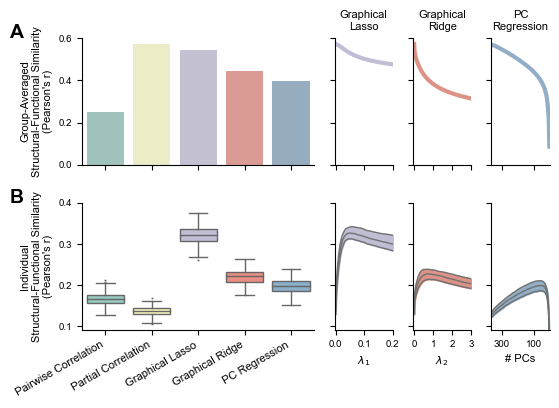

In [12]:
fig,axs = plt.subplots(2,4,figsize=(5.5,4),sharex='col',sharey='row',gridspec_kw={'hspace':.3,'wspace':.2,'width_ratios':[4,1,1,1]})
fig.subplots_adjust(left=.14,right=0.99,top=.91,bottom=.18)

# Colors for graph lasso, graph ridge, and pc regress param plots
colors_ = [[.753,.745,.835],[.867,.573,.529],[.573,.682,.776]]
grey = [.439,.443,.439]

methodsPrintedLabels = ['Pairwise Correlation','Partial Correlation','Graphical Lasso','Graphical Ridge','PC Regression']

# Loop through metrics (rows)
for n in range(2):
    if n==0: 
        boxData = sfSimAvgDF
        paramData = sfSimAvgByParam
    elif n==1:
        boxData = sfSimDF
        paramData = sfSimByParam

    # Make boxplots
    if n==0:
        sns.barplot(x='Method',y="Data",data=boxData,palette="Set3",ax=axs[n,0],saturation=.5)
    else:
        sns.boxplot(x='Method',y="Data",data=boxData,palette="Set3",ax=axs[n,0],fliersize=.5,linewidth=1)

    # Make hyperparameter line plots
    for m,method in enumerate(['graphicalLasso','graphicalRidge','pcRegression']):
        
        if n==0:
            axs[n,m+1].plot(paramsFull[method],paramData[method],color=colors_[m],linewidth=3)
        else:
            med = np.nanmedian(paramData[method],axis=0)
            pct25 = np.nanpercentile(paramData[method],25,axis=0)
            pct75 = np.nanpercentile(paramData[method],75,axis=0)
            axs[n,m+1].fill_between(paramsFull[method],pct25,pct75,color=colors_[m],alpha=1)
            axs[n,m+1].plot(paramsFull[method],med,color=grey,linewidth=1)
            axs[n,m+1].plot(paramsFull[method],pct25,color=grey,linewidth=1)
            axs[n,m+1].plot(paramsFull[method],pct75,color=grey,linewidth=1)
        
        ylims = axs[n,0].get_ylim()
        axs[n,m+1].set_ylim(ylims)

# X-axis method labels
axs[1,0].set_xticklabels(methodsPrintedLabels, rotation=30, size=8, ha='right',ma='right',rotation_mode='default')
for a in range(2):
    axs[a,0].set_xlabel('')    

# X-axis hyperparams labels
axs[1,1].set_xlim(-.004,.2)
axs[1,2].set_xlim(-.06,3)
axs[1,3].set_xlim(365,0)

axs[1,1].set_xticks([0,.1,.2])
axs[1,2].set_xticks([0,1,2,3])
axs[1,3].set_xticks([300,100])

axs[1,1].set_xlabel('$\lambda_1$',size=8)
axs[1,2].set_xlabel('$\lambda_2$',size=8)
axs[1,3].set_xlabel('# PCs',size=8)

# Y-axis labels
axs[0,0].set_ylabel("Group-Averaged\nStructural-Functional Similarity\n(Pearson's r)",size=8)
axs[1,0].set_ylabel("Individual\nStructural-Functional Similarity\n(Pearson's r)",size=8)
axs[1,0].set_yticks([.1,.2,.3,.4])

# Set right-panel titles
axs[0,1].set_title('Graphical\nLasso',fontsize=8)
axs[0,2].set_title('Graphical\nRidge',fontsize=8)
axs[0,3].set_title('PC\nRegression',fontsize=8)

# Remove borders   
for a1 in range(2):
    for a2 in range(4):
        axs[a1,a2].spines.right.set_visible(False)
        axs[a1,a2].spines.top.set_visible(False)

# Add figure lettering
for m,letter in enumerate(['A','B']):
    axs[m,0].text(-2.05,axs[m,0].get_ylim()[1],letter,fontsize=14,ha='left',weight='bold')

if dataset == 'discovery':
    fig.savefig(f'{figDir}/Figure4.pdf',dpi=600,transparent=True)
if dataset == 'replication':
    fig.savefig(f'{figDir}/FigureS2.pdf',dpi=600,transparent=True)
    

## Supplemental Analysis - Matched Sparsities

SC mean density = 8.830, SD = 1.026

pairwiseCorr
original
	group-averaged struct-func similarity: r = 0.250
	individual struct-func similarity: mean r = 0.168, SD = 0.016
matching SC sparsity
	group-averaged struct-func similarity: r = 0.370
	individual struct-func similarity: mean r = 0.246, SD = 0.030

partialCorr
original
	group-averaged struct-func similarity: r = 0.572
	individual struct-func similarity: mean r = 0.137, SD = 0.011
matching SC sparsity
	group-averaged struct-func similarity: r = 0.603
	individual struct-func similarity: mean r = 0.274, SD = 0.026

graphicalLasso
original
	group-averaged struct-func similarity: r = 0.543
	individual struct-func similarity: mean r = 0.322, SD = 0.022
matching SC sparsity
	group-averaged struct-func similarity: r = 0.549
	individual struct-func similarity: mean r = 0.350, SD = 0.024

graphicalRidge
original
	group-averaged struct-func similarity: r = 0.444
	individual struct-func similarity: mean r = 0.222, SD = 0.017
matching SC spa

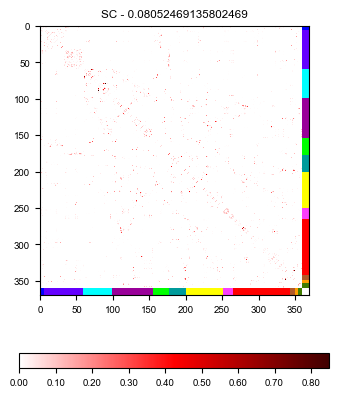

In [13]:
SC = np.load(f'{dataDir}/empirical/connectivity/structural_cortex_{dataset}.npy')

ses = '1'
scVec = SC[np.triu_indices(nNodes,k=1)]
scSparsity = 100 - (np.sum(scVec>0,axis=0)/nEdges * 100)
print(f'SC mean density = {np.mean(100-scSparsity):.3f}, SD = {np.std(100-scSparsity):.3f}')
print()

plt.figure(figsize=(4,5))
axs = plt.gca()
axs,im = plotMatrix_cabnpNetColors(axs,SC[:,:,0],positions=['right','bottom'],buffer=10)
plt.colorbar(im,format="%0.2f",orientation='horizontal')
plt.title(f'SC - {np.mean(SC[:,:,0]!=0)}')
    
# Calculate individual and group-averaged structural-functional similarity
sfSimDF_matchSparsity = pd.DataFrame(data={'Method':[],'Data':[]})
sfSimAvgDF_matchSparsity = pd.DataFrame(data={'Method':[],'Data':[]})
matchingSparsityFC = {}

for m,method in enumerate(methodsList):
    matchingSparsityFC[method] = FC[method][ses].copy()
    for s,subj in enumerate(subjList):
        boundaryWt = np.percentile(FC[method][ses][np.triu_indices(nNodes,k=1)][:,s],scSparsity[s])
        matchingSparsityFC[method][:,:,s][FC[method][ses][:,:,s] < boundaryWt] = 0
        #matchingSparsityFC[method][:,:,s][matchingSparsityFC[method][:,:,s] < 0] += boundaryWt
        matchingSparsityFC[method][:,:,s][matchingSparsityFC[method][:,:,s] > 0] -= boundaryWt
    #print(np.sum(matchingSparsityFC[method]<0,axis=(0,1)))
        
    tmpDF = pd.DataFrame(data={'Method':[],'Data':[]})
    tmpDF['Data'] = matrixSimilarity(matchingSparsityFC[method],SC)
    tmpDF['Method'] = method
    sfSimDF_matchSparsity = pd.concat([sfSimDF_matchSparsity,tmpDF])
    
    tmpDF = pd.DataFrame(data={'Method':[],'Data':[]})
    tmpDF.loc[0,'Data'] = matrixSimilarity(np.mean(matchingSparsityFC[method],axis=2),np.mean(SC,axis=2))
    tmpDF.loc[0,'Method'] = method
    sfSimAvgDF_matchSparsity = pd.concat([sfSimAvgDF_matchSparsity,tmpDF])
    
    print(f'{method}')
    print('original')
    print(f'\tgroup-averaged struct-func similarity: r = {sfSimAvgDF.loc[sfSimAvgDF["Method"]==method,"Data"].values[0]:.3f}')
    print(f'\tindividual struct-func similarity: mean r = {np.mean(sfSimDF.loc[sfSimDF["Method"]==method,"Data"]):.3f}, SD = {np.std(sfSimDF.loc[sfSimDF["Method"]==method,"Data"]):.3f}')
    print('matching SC sparsity')
    print(f'\tgroup-averaged struct-func similarity: r = {sfSimAvgDF_matchSparsity.loc[sfSimAvgDF_matchSparsity["Method"]==method,"Data"].values[0]:.3f}')
    print(f'\tindividual struct-func similarity: mean r = {np.mean(sfSimDF_matchSparsity.loc[sfSimDF_matchSparsity["Method"]==method,"Data"]):.3f}, SD = {np.std(sfSimDF_matchSparsity.loc[sfSimDF_matchSparsity["Method"]==method,"Data"]):.3f}')
    print()
    

In [14]:
methodsPrintedLabels = ['Pairwise Correlation','Partial Correlation','Graphical Lasso','Graphical Ridge','PC Regression']
colNames = [(' ','Methods'),("Structural-Functional Similarity (Pearson's r)","Group-Averaged"),("Structural-Functional Similarity (Pearson's r)","Individual")]

tableFilename = f'{figDir}/tableS2.tsv'
if os.path.exists(tableFilename):
    tableDF = pd.read_csv(tableFilename,sep='\t',index_col=0,header=[0,1])
else:
    tableDF = pd.DataFrame(columns=pd.MultiIndex.from_tuples(colNames, names=["line1", "line2"]))

i = 1
for m1,method1 in enumerate(methodsList):
    for m2,method2 in enumerate(methodsList):
        if m2 <= m1:
            continue
        tableDF.loc[i,(' ','Methods')] = f'{methodsPrintedLabels[m1]} vs. {methodsPrintedLabels[m2]}'
        
        diff = np.tanh(np.arctanh(sfSimAvgDF_matchSparsity.loc[sfSimAvgDF_matchSparsity['Method']==method1,'Data'].values[0])-np.arctanh(sfSimAvgDF_matchSparsity.loc[sfSimAvgDF_matchSparsity['Method']==method2,'Data'].values[0]))
        Z,p = correlatedCorrelations(sfSimAvgDF_matchSparsity.loc[sfSimAvgDF_matchSparsity['Method']==method1,'Data'].values[0],sfSimAvgDF_matchSparsity.loc[sfSimAvgDF_matchSparsity['Method']==method2,'Data'].values[0],matrixSimilarity(np.mean(matchingSparsityFC[method1],axis=2),np.mean(matchingSparsityFC[method2],axis=2)),nSubjs)
        tableStr = f'∆r = {diff:.3f}, Z = {formatTStat(Z)}, p {formatPVal(p)}'
        tableDF.loc[i,("Structural-Functional Similarity (Pearson's r)","Group-Averaged")] = tableStr
        
        diff = np.mean(sfSimDF_matchSparsity.loc[sfSimDF_matchSparsity['Method']==method1,'Data']-sfSimDF_matchSparsity.loc[sfSimDF_matchSparsity['Method']==method2,'Data'])
        [t,p] = stats.ttest_rel(sfSimDF_matchSparsity.loc[sfSimDF_matchSparsity['Method']==method1,'Data'],sfSimDF_matchSparsity.loc[sfSimDF_matchSparsity['Method']==method2,'Data'])
        tableStr = f'mean ∆r = {diff:.3f}, T({nSubjs-1}) = {formatTStat(t)}, p {formatPVal(p)}'
        tableDF.loc[i,("Structural-Functional Similarity (Pearson's r)","Individual")] = tableStr
        
        i+=1
        
print(tableDF)
tableDF.to_csv(tableFilename,sep='\t') 


line1                                                \
line2                                       Methods   
1      Pairwise Correlation vs. Partial Correlation   
2          Pairwise Correlation vs. Graphical Lasso   
3          Pairwise Correlation vs. Graphical Ridge   
4            Pairwise Correlation vs. PC Regression   
5           Partial Correlation vs. Graphical Lasso   
6           Partial Correlation vs. Graphical Ridge   
7             Partial Correlation vs. PC Regression   
8               Graphical Lasso vs. Graphical Ridge   
9                 Graphical Lasso vs. PC Regression   
10                Graphical Ridge vs. PC Regression   

line1 Structural-Functional Similarity (Pearson's r)  \
line2                                 Group-Averaged   
1                 ∆r = -0.300, Z = -4.58, p < .00001   
2                  ∆r = -0.224, Z = -3.83, p = .0001   
3                   ∆r = -0.178, Z = -3.04, p = .002   
4                   ∆r = -0.117, Z = -2.15, p = .032   
5  

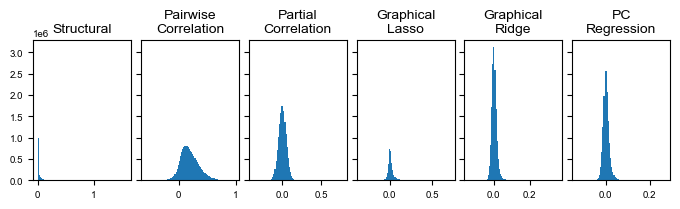

In [15]:
fig,axs = plt.subplots(1,6,figsize=(6.5,2),gridspec_kw={'wspace':.1},sharey='row')
fig.subplots_adjust(left=.015,right=0.995,top=.8,bottom=.1)

methodsListWithSC = ['structural','pairwiseCorr','partialCorr','graphicalLasso','graphicalRidge','pcRegression']
methodsPrintedLabels = ['Structural','Pairwise\nCorrelation','Partial\nCorrelation','Graphical\nLasso','Graphical\nRidge','PC\nRegression']
matchingSparsityFC['structural'] = SC.copy()

for m,method in enumerate(methodsListWithSC):
    if m == 0:
        edgesVec = SC[np.triu_indices(nNodes,k=1)]
    else:
        edgesVec = FC[method][ses][np.triu_indices(nNodes,k=1)]
    edgesVec[abs(edgesVec)==.0] = np.nan    
    
    axs[m].set_title(methodsPrintedLabels[m],size=10)
    if m == 0:
        axs[m].hist(edgesVec.flatten(),bins=80)#**np.arange(-2,0.15,.4))
        #axs[m].set_xscale('log')
    else:
        axs[m].hist(edgesVec.flatten(),bins=80)
    #axs[m].set_yscale('log')
    
if dataset == 'discovery':
    fig.savefig(f'{figDir}/figS3-0.pdf',dpi=600,transparent=True)
   

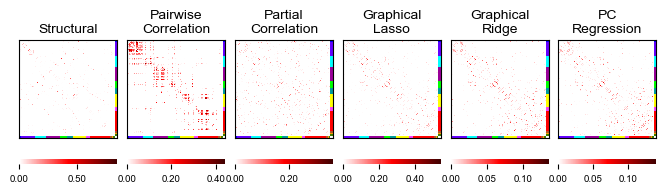

In [16]:
fig,axs = plt.subplots(1,6,figsize=(6.5,2),gridspec_kw={'wspace':.1})
fig.subplots_adjust(left=.015,right=0.995,top=.8,bottom=.1)

methodsListWithSC = ['structural','pairwiseCorr','partialCorr','graphicalLasso','graphicalRidge','pcRegression']
methodsPrintedLabels = ['Structural','Pairwise\nCorrelation','Partial\nCorrelation','Graphical\nLasso','Graphical\nRidge','PC\nRegression']

matchingSparsityFC['structural'] = SC.copy()

for m,method in enumerate(methodsListWithSC):
    axs[m],im = plotMatrix_cabnpNetColors(axs[m],matchingSparsityFC[method][:,:,0],positions=['right','bottom'],buffer=10)
    axs[m].set_xticks([]); axs[m].set_yticks([])
    cb = plt.colorbar(im,format="%0.2f",orientation='horizontal')
    cb.outline.set_visible(False)
    axs[m].set_title(methodsPrintedLabels[m],size=10)
    
if dataset == 'discovery':
    fig.savefig(f'{figDir}/figS3-1.pdf',dpi=600,transparent=True)
   

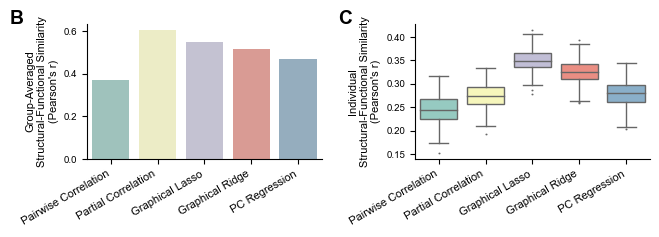

In [17]:
fig,axs = plt.subplots(1,2,figsize=(6.5,2.25),gridspec_kw={'wspace':.4,'width_ratios':[1,1]})
fig.subplots_adjust(left=.125,right=0.99,top=.91,bottom=.31)

methodsPrintedLabels = ['Pairwise Correlation','Partial Correlation','Graphical Lasso','Graphical Ridge','PC Regression']

# Loop through metrics
for n in range(2):
    if n==0: 
        boxData = sfSimAvgDF_matchSparsity
    elif n==1:
        boxData = sfSimDF_matchSparsity

    # Make boxplots
    if n==0:
        sns.barplot(x='Method',y="Data",data=boxData,palette="Set3",ax=axs[n],saturation=.5)
    else:
        sns.boxplot(x='Method',y="Data",data=boxData,palette="Set3",ax=axs[n],fliersize=.5,linewidth=1)

    # X-axis method labels
    axs[n].set_xticklabels(methodsPrintedLabels, rotation=30, size=8, ha='right',ma='right',rotation_mode='default')
    axs[n].set_xlabel('')    

# Y-axis labels
axs[0].set_ylabel("Group-Averaged\nStructural-Functional Similarity\n(Pearson's r)",size=8)
axs[1].set_ylabel("Individual\nStructural-Functional Similarity\n(Pearson's r)",size=8)

# Remove borders   
for a1 in range(2):
    axs[a1].spines.right.set_visible(False)
    axs[a1].spines.top.set_visible(False)

# Add figure lettering
for m,letter in enumerate(['B','C']):
    axs[m].text(-2.15,axs[m].get_ylim()[1],letter,fontsize=14,ha='left',weight='bold')

if dataset == 'discovery':
    fig.savefig(f'{figDir}/figS3.pdf',dpi=600,transparent=True)
    

# Motion Correlation

In [18]:
fcVec = {}
fcVec_isNonzero = {}

NONZERO_THRESH = .01
PCT_SUBJS_THRESH = .8

for m,method in enumerate(methodsList):
    fcVec[method] = FC[method]['1'][np.triu_indices(nNodes,k=1)]
    
    fcVec_isNonzero[method] = np.full((fcVec[method].shape),True)
    fcVec_isNonzero[method][abs(fcVec[method])<NONZERO_THRESH] = False
    fcVec_isNonzero[method][np.mean(fcVec_isNonzero[method],axis=1)<PCT_SUBJS_THRESH,:] = False
    print(f'{method}: {np.sum(np.sum(fcVec_isNonzero[method],axis=1)>0)} nonzero edges, {np.sum(np.sum(fcVec_isNonzero[method],axis=1)>0)/nEdges*100:.4f}% of total')
    

pairwiseCorr: 64620 nonzero edges, 100.0000% of total
partialCorr: 60169 nonzero edges, 93.1120% of total
graphicalLasso: 717 nonzero edges, 1.1096% of total
graphicalRidge: 2771 nonzero edges, 4.2881% of total
pcRegression: 2995 nonzero edges, 4.6348% of total


In [19]:
import statsmodels.api as sm
import CombinedFC.CombinedFCToolBox as cfc

relativeRMS = np.full((nSubjs,2),np.nan)

for s,subj in enumerate(subjList):
    for r,run in enumerate(['rfMRI_REST1_PA','rfMRI_REST1_AP']):
        
        relRMSFile = f'/projects/f_mc1689_1/AgingHubs/data/preprocessed/{subj}_V1_MR/MNINonLinear/Results/{run}/Movement_RelativeRMS_mean.txt'
        h = open(relRMSFile,'r')
        rms = h.readlines()
        relativeRMS[s,r] = float(rms[0])
        
relativeRMS = np.mean(relativeRMS,axis=1) 

subjSex = subjectsDF['sex'].values
subjSex[subjSex=='M'] = 0
subjSex[subjSex=='F'] = 1

QCFC = {}
QCFC_nonzero = {}
QCFC_pvals = {}
QCFC_nonzero_pvals = {}
QCFC_pvals_FDR = {}
QCFC_nonzero_pvals_FDR = {}

for method in methodsList:
    QCFC[method] = np.full((nEdges,1),np.nan)
    QCFC_nonzero[method] = np.full((nEdges,1),np.nan)
    
    Fz_nonzero = np.full((nEdges,1),np.nan)
    
    for n in range(nEdges):
        d = np.vstack([fcVec[method][n,:],relativeRMS,subjAge,subjSex]).astype(float).T
        QCFC[method][n] = parCorrInvCov(d)[0][0,1]
        
        if np.sum(fcVec_isNonzero[method][n,:]) > 0:
            d = np.vstack([fcVec[method][n,fcVec_isNonzero[method][n,:]],relativeRMS[fcVec_isNonzero[method][n,:]],subjAge[fcVec_isNonzero[method][n,:]],subjSex[fcVec_isNonzero[method][n,:]]]).astype(float).T
            QCFC_nonzero[method][n] = parCorrInvCov(d)[0][0,1]
            Fz_nonzero[n] = cfc.fisherZTrans(QCFC_nonzero[method][n],np.sum(fcVec_isNonzero[method][n,:]),Ho=0,condSetSize=2)
    
    Fz_nonzero = Fz_nonzero[~np.isnan(Fz_nonzero)]
    QCFC_nonzero_pvals[method] = cfc.pvalue(Fz_nonzero)
    [tmp,QCFC_nonzero_pvals_FDR[method]] = sm.stats.fdrcorrection(QCFC_nonzero_pvals[method].flatten())
    
    Fz = cfc.fisherZTrans(QCFC[method],nSubjs,Ho=0,condSetSize=2)
    Fz = Fz[~np.isnan(Fz)]
    QCFC_pvals[method] = cfc.pvalue(Fz)
    [tmp,QCFC_pvals_FDR[method]] = sm.stats.fdrcorrection(QCFC_pvals[method].flatten())
    
    print(method)
    print(f'All edges: {np.median(abs(QCFC[method])):.6f} median absolute QC-FC correlation')
    print(f'All edges: {np.mean(QCFC_pvals_FDR[method]<=.05)*100:.4f}% edges with significant correlation')
    print(f'Nonzero edges: {np.nanmedian(abs(QCFC_nonzero[method])):.6f} median absolute QC-FC correlation')
    print(f'Nonzero edges: {np.mean(QCFC_nonzero_pvals_FDR[method]<=.05)*100:.4f}% edges with significant correlation')
    print()
    

            

pairwiseCorr
All edges: 0.156859 median absolute QC-FC correlation
All edges: 56.4082% edges with significant correlation
Nonzero edges: 0.157248 median absolute QC-FC correlation
Nonzero edges: 55.5617% edges with significant correlation

partialCorr
All edges: 0.044592 median absolute QC-FC correlation
All edges: 0.0000% edges with significant correlation
Nonzero edges: 0.048664 median absolute QC-FC correlation
Nonzero edges: 0.0000% edges with significant correlation

graphicalLasso
All edges: 0.047681 median absolute QC-FC correlation
All edges: 0.0124% edges with significant correlation
Nonzero edges: 0.060275 median absolute QC-FC correlation
Nonzero edges: 3.2078% edges with significant correlation

graphicalRidge
All edges: 0.050396 median absolute QC-FC correlation
All edges: 0.0511% edges with significant correlation
Nonzero edges: 0.065007 median absolute QC-FC correlation
Nonzero edges: 1.9848% edges with significant correlation

pcRegression
All edges: 0.051952 median abs

# Task Prediction (Actflow)

In [20]:
from metrics.activityPrediction import activityPrediction
print(dataset)
task = 'carit2'
taskAct = np.load(f'{dataDir}/postproc/taskActivations_{parcType}_{task}_{dataset}.npy')
print(taskAct.shape)

ses = '1'

# Calculate actflow (task activation prediction) accuracy
taskPredrDF = pd.DataFrame(data={'Method':[],'Data':[]})
taskPredR2DF = pd.DataFrame(data={'Method':[],'Data':[]})
for m,method in enumerate(methodsList):
    #break
    R2,r = activityPrediction(taskAct,FC[method][ses])
    
    tmpDF = pd.DataFrame(data={'Method':[],'Data':[]})
    tmpDF['Data'] = r
    tmpDF['Method'] = method
    taskPredrDF = pd.concat([taskPredrDF,tmpDF])
    
    tmpDF = pd.DataFrame(data={'Method':[],'Data':[]})
    tmpDF['Data'] = R2
    tmpDF['Method'] = method
    taskPredR2DF = pd.concat([taskPredR2DF,tmpDF])
    
    R2Hit,rHit = activityPrediction(taskAct[:,0:1,0],FC[method][ses][:,:,0])
    
    print(f'{method}')
    print(f'Indiv subj, hit, r = {rHit[0]:.3f}, R^2 = {R2Hit[0]:.3f}')
    print(f'Task prediction: mean r = {np.mean(taskPredrDF.loc[taskPredrDF["Method"]==method,"Data"]):.3f}, SD = {np.std(taskPredrDF.loc[taskPredrDF["Method"]==method,"Data"]):.3f}')
    print(f'Task prediction: mean R^2 = {np.mean(taskPredR2DF.loc[taskPredR2DF["Method"]==method,"Data"]):.3f}, SD = {np.std(taskPredR2DF.loc[taskPredR2DF["Method"]==method,"Data"]):.3f}')
    print()
    

discovery
(360, 2, 236)
pairwiseCorr
Indiv subj, hit, r = 0.481, R^2 = -212.240
Task prediction: mean r = 0.488, SD = 0.119
Task prediction: mean R^2 = -2392.232, SD = 3490.599

partialCorr
Indiv subj, hit, r = 0.500, R^2 = 0.006
Task prediction: mean r = 0.569, SD = 0.106
Task prediction: mean R^2 = 0.179, SD = 0.202

graphicalLasso
Indiv subj, hit, r = 0.719, R^2 = 0.515
Task prediction: mean r = 0.719, SD = 0.086
Task prediction: mean R^2 = 0.521, SD = 0.119

graphicalRidge
Indiv subj, hit, r = 0.692, R^2 = 0.479
Task prediction: mean r = 0.694, SD = 0.090
Task prediction: mean R^2 = 0.489, SD = 0.121

pcRegression
Indiv subj, hit, r = 0.684, R^2 = 0.468
Task prediction: mean r = 0.684, SD = 0.093
Task prediction: mean R^2 = 0.475, SD = 0.123



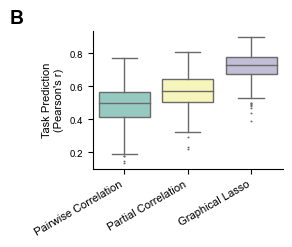

In [21]:
fig,axs = plt.subplots(1,1,figsize=(2.8,2.3))
fig.subplots_adjust(left=.3,right=0.98,top=.9,bottom=.30)

methodsPrintedLabels = ['Pairwise Correlation','Partial Correlation','Graphical Lasso']

taskPredrDFplt = taskPredrDF.loc[(taskPredrDF['Method']=='pairwiseCorr')|(taskPredrDF['Method']=='partialCorr')|(taskPredrDF['Method']=='graphicalLasso')].copy()
boxData = taskPredrDFplt

# Make boxplots
sns.boxplot(x='Method',y="Data",data=boxData,palette="Set3",ax=axs,fliersize=.5,linewidth=1)
       
# X-axis method labels
axs.set_xticklabels(methodsPrintedLabels, rotation=30, size=8, ha='right',ma='right',rotation_mode='default')
axs.set_xlabel('')    

# Y-axis labels
axs.set_ylabel("Task Prediction\n(Pearson's r)",size=8)

# Remove borders   
axs.spines.right.set_visible(False)
axs.spines.top.set_visible(False)

# Add figure lettering
axs.text(-1.8,axs.get_ylim()[1]*1.05,'B',fontsize=14,ha='left',weight='bold')

if dataset == 'discovery':
    fig.savefig(f'{figDir}/fig8_boxplots.pdf',dpi=600,transparent=True)
    

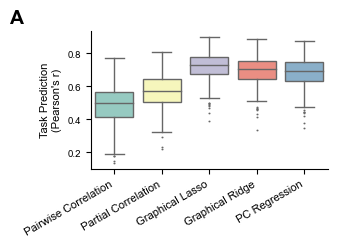

In [22]:
fig,axs = plt.subplots(1,1,figsize=(3.25,2.3))
fig.subplots_adjust(left=.25,right=0.98,top=.9,bottom=.30)

taskPredrDFplt = taskPredrDF.loc[(taskPredrDF['Method']=='pairwiseCorr')|(taskPredrDF['Method']=='partialCorr')|(taskPredrDF['Method']=='graphicalLasso')].copy()

methodsPrintedLabels = ['Pairwise Correlation','Partial Correlation','Graphical Lasso','Graphical Ridge','PC Regression']

boxData = taskPredrDF

# Make boxplots
sns.boxplot(x='Method',y="Data",data=boxData,palette="Set3",ax=axs,fliersize=.5,linewidth=1)
       
# X-axis method labels
axs.set_xticklabels(methodsPrintedLabels, rotation=30, size=8, ha='right',ma='right',rotation_mode='default')
axs.set_xlabel('')    

# Y-axis labels
axs.set_ylabel("Task Prediction\n(Pearson's r)",size=8)

# Remove borders   
axs.spines.right.set_visible(False)
axs.spines.top.set_visible(False)

# Add figure lettering
if dataset == 'discovery':
    axs.text(-2.2,axs.get_ylim()[1]*1.05,'A',fontsize=14,ha='left',weight='bold')
elif dataset == 'replication':
    axs.text(-2.2,axs.get_ylim()[1]*1.05,'B',fontsize=14,ha='left',weight='bold')

fig.savefig(f'{figDir}/figS_actflow_boxplots_{dataset}.pdf',dpi=600,transparent=True)
    

(360, 2, 236)
pairwiseCorr - r = [0.48054294], R^2 = [-212.2404166]
partialCorr - r = [0.50006426], R^2 = [0.00609457]
graphicalLasso - r = [0.71898865], R^2 = [0.5148924]
graphicalRidge - r = [0.69232601], R^2 = [0.4789545]
pcRegression - r = [0.68417479], R^2 = [0.4678631]


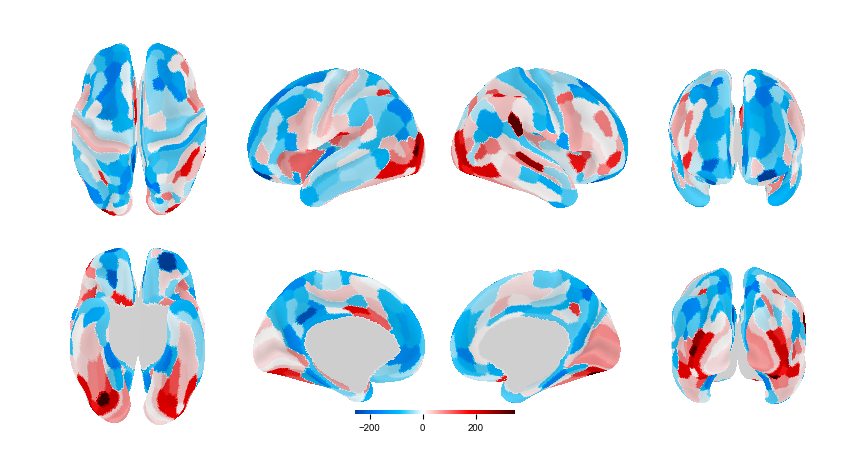

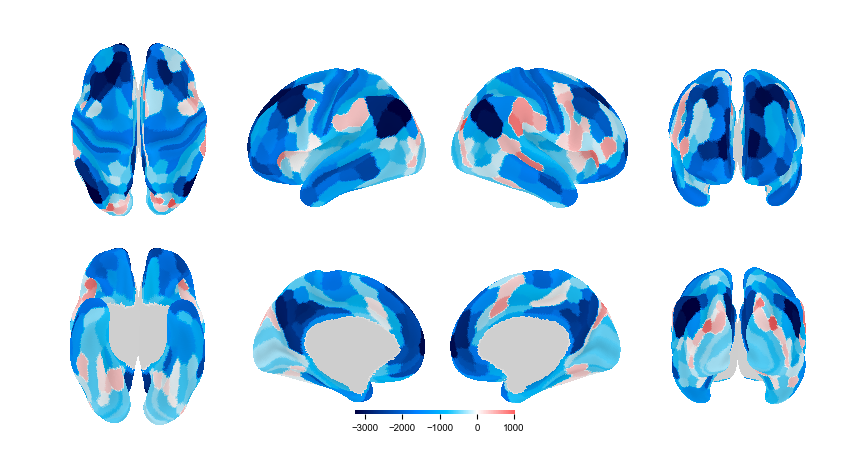

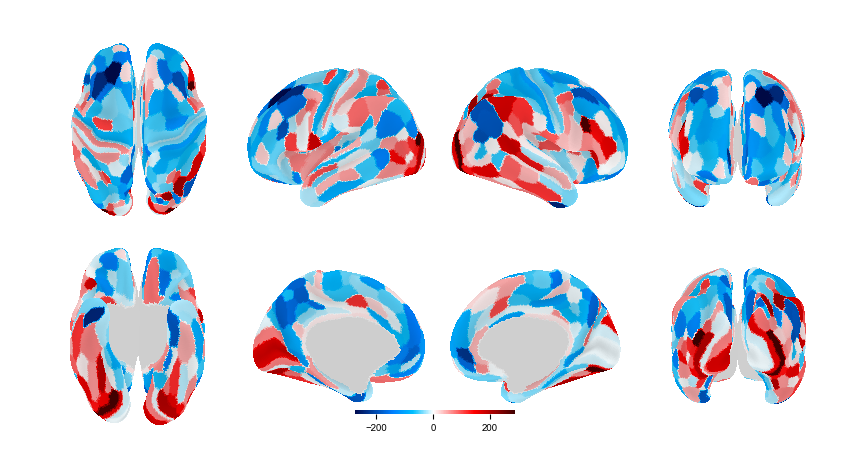

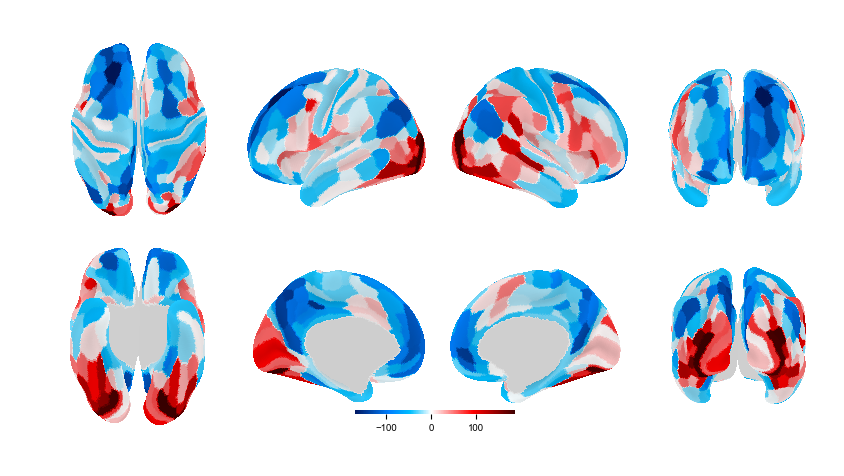

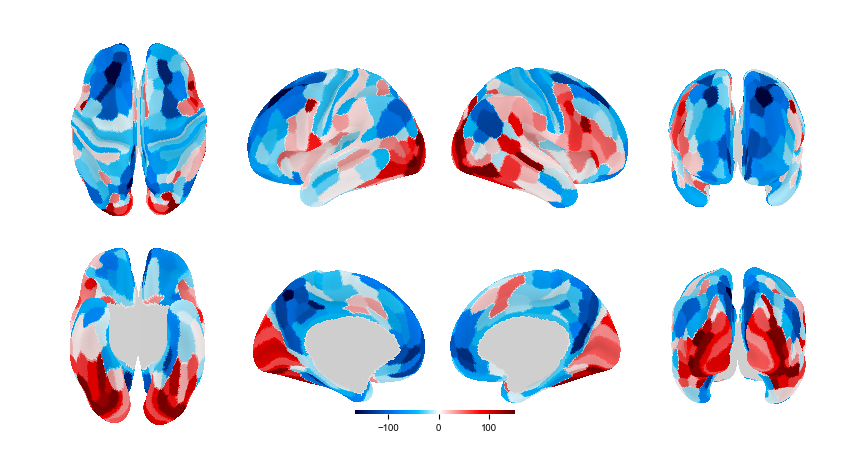

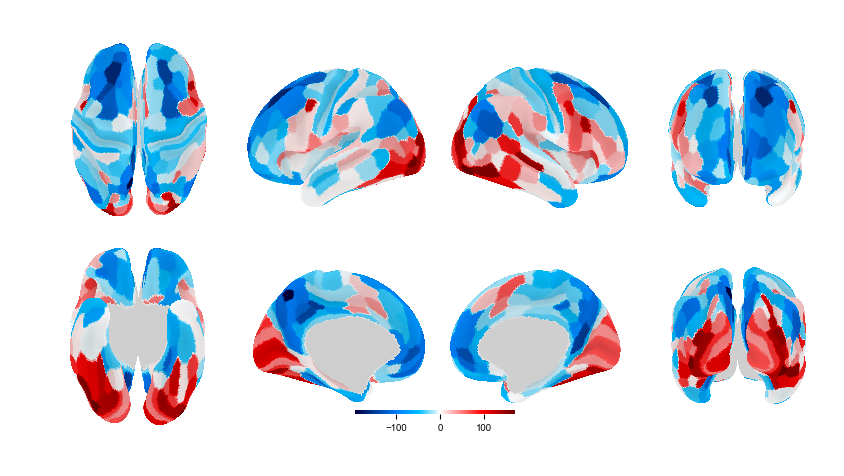

In [23]:
from metrics.activityPrediction import activityPrediction

task = 'carit2'
taskAct = np.load(f'{dataDir}/postproc/taskActivations_{parcType}_{task}_{dataset}.npy')
print(taskAct.shape)

ses = '1'

figSurf = plotToCortex(taskAct[:,0,0][parcOrderReverse])
figSurf.savefig(f'{figDir}/fig8_surf_taskAct.pdf',transparent=True)
figSurf.savefig(f'{figDir}/fig8_surf_taskAct.png',transparent=True,dpi=600)

for m,method in enumerate(methodsList):
    R2Hit,rHit,pred = activityPrediction(taskAct[:,0:1,0],FC[method][ses][:,:,0],outputPred=True)
    print(f'{method} - r = {rHit}, R^2 = {R2Hit}')
    figSurf = plotToCortex(pred[parcOrderReverse].squeeze())
    figSurf.savefig(f'{figDir}/fig8_surf_{method}.pdf',transparent=True)
    figSurf.savefig(f'{figDir}/fig8_surf_{method}.png',transparent=True,dpi=600)
    

In [24]:
methodsPrintedLabels = ['Pairwise Correlation','Partial Correlation','Graphical Lasso','Graphical Ridge','PC Regression']
colNames = [(' ','Methods'),("Task Activity Prediction (Pearson's r)",'discovery'),("Task Activity Prediction (Pearson's r)","replication"),("Age Prediction (Pearson's r)",'discovery'),("Age Prediction (Pearson's r)","replication"),("Intelligence Prediction (Pearson's r)",'discovery'),("Intelligence Prediction (Pearson's r)",'replication')]

tableFilename = f'{figDir}/tableS_preds.tsv'
if os.path.exists(tableFilename):
    tableDF = pd.read_csv(tableFilename,sep='\t',index_col=0,header=[0,1])
else:
    tableDF = pd.DataFrame(columns=pd.MultiIndex.from_tuples(colNames, names=["line1", "line2"]))

i = 1
for m1,method1 in enumerate(methodsList):
    for m2,method2 in enumerate(methodsList):
        if m2 <= m1:
            continue
        tableDF.loc[i,(' ','Methods')] = f'{methodsPrintedLabels[m1]} vs. {methodsPrintedLabels[m2]}'
        
        diff = np.mean(taskPredrDF.loc[taskPredrDF['Method']==method1,'Data']-taskPredrDF.loc[taskPredrDF['Method']==method2,'Data'])
        [t,p] = stats.ttest_rel(taskPredrDF.loc[taskPredrDF['Method']==method1,'Data'],taskPredrDF.loc[taskPredrDF['Method']==method2,'Data'])
        tableStr = f'mean ∆r = {diff:.3f}, T({nSubjs-1}) = {formatTStat(t)}, p {formatPVal(p)}'
        tableDF.loc[i,("Task Activity Prediction (Pearson's r)",dataset)] = tableStr
        
        i+=1
        
print(tableDF)
tableDF.to_csv(tableFilename,sep='\t')


line1                                                \
line2                                       Methods   
1      Pairwise Correlation vs. Partial Correlation   
2          Pairwise Correlation vs. Graphical Lasso   
3          Pairwise Correlation vs. Graphical Ridge   
4            Pairwise Correlation vs. PC Regression   
5           Partial Correlation vs. Graphical Lasso   
6           Partial Correlation vs. Graphical Ridge   
7             Partial Correlation vs. PC Regression   
8               Graphical Lasso vs. Graphical Ridge   
9                 Graphical Lasso vs. PC Regression   
10                Graphical Ridge vs. PC Regression   

line1        Task Activity Prediction (Pearson's r)  \
line2                                     discovery   
1      mean ∆r = -0.081, T(235) = -16.4, p < .00001   
2      mean ∆r = -0.231, T(235) = -48.9, p < .00001   
3      mean ∆r = -0.206, T(235) = -46.1, p < .00001   
4      mean ∆r = -0.196, T(235) = -43.9, p < .00001   
5      me

# Age and g Prediction

In [ ]:
measuresFile = f'{dataDir}/empirical/indivDiffs/indivDiffMeasures.tsv'
indivDiffsFile = f'{dataDir}/empirical/indivDiffs/indivDiffs_{dataset}_.csv'

measuresDF = pd.read_csv(measuresFile,sep='\t',index_col='measures')

indivDiffs = {}
for measure in measuresDF.index:
    indivDiffs[measure] = np.zeros((nSubjs))
    
    file = f'{dataDir}/downloads/{measuresDF.loc[measure,"filename"]}'
    col = measuresDF.loc[measure,"colname"]
    print(file,col)
    tmpDF = pd.read_csv(file,sep='\t')
    for s,subj in enumerate(subjList):
        tmp = tmpDF.loc[tmpDF["src_subject_id"]==subj,col].values
        if len(tmp)==0:
            tmp = np.nan
        elif len(tmp) > 1:
            tmp = tmp.astype(float)
            tmp = tmp[~np.isnan(tmp)]
            tmp = tmp[tmp!=999]
            if len(tmp)==0:
                tmp = np.nan
        else:
            tmp = float(tmp)
        indivDiffs[measure][s] = tmp
        
indivDiffsDF = pd.DataFrame(data=indivDiffs,index=subjList)

subjsWithBeh = np.full((len(indivDiffsDF.index)),True)
for measure in indivDiffsDF.columns:
    subjsWithBeh = subjsWithBeh & indivDiffsDF[measure].notna().values
    
indivDiffsSubjsIdx = subjsWithBeh# & (subjGroup=='YA')
print(np.sum(indivDiffsSubjsIdx))
print(subjList[~indivDiffsSubjsIdx])
indivDiffsDF = indivDiffsDF.loc[indivDiffsSubjsIdx]
print(indivDiffsDF)

indivDiffsDF.to_csv(indivDiffsFile,sep=',')

In [ ]:
indivDiffsFile = f'{dataDir}/empirical/indivDiffs/indivDiffs_{dataset}_.csv'
loadsFile = f'{dataDir}/empirical/indivDiffs/gMeasureLoads_{dataset}_.csv'
scoresFile = f'{dataDir}/empirical/indivDiffs/gSubjScores_{dataset}_.csv'

setupCommand = ''
setupCommand = setupCommand + 'export PATH=/home/klp173/R/4.1.0/bin:$PATH; '
setupCommand = setupCommand + 'export C_INCLUDE_PATH=/home/klp173/R/4.1.0/include:$C_INCLUDE_PATH; '
setupCommand = setupCommand + 'export CPLUS_INCLUDE_PATH=/home/klp173/R/4.1.0/include:$CPLUS_INCLUDE_PATH; '
setupCommand = setupCommand + 'export LIBRARY_PATH=/home/klp173/R/4.1.0/lib:$LIBRARY_PATH; '
setupCommand = setupCommand + 'export LD_LIBRARY_PATH=/home/klp173/R/4.1.0/lib:/home/klp173/R/4.1.0/lib64/R/lib:$LD_LIBRARY_PATH; '
setupCommand = setupCommand + 'export MANPATH=/home/klp173/R/4.1.0/share/man:$MANPATH; '

command = setupCommand + "Rscript -e '"
command = command + f'library(psych); '
command = command + f'library(nFactors); '
command = command + f'indivDiffs <- read.csv("{indivDiffsFile}"); '
command = command + f'row.names(indivDiffs) <- indivDiffs[, 1]; '
command = command + f'indivDiffs <- indivDiffs[, -1]; '
command = command + f'faOutput <- fa(indivDiffs, nfactors=1, covar=FALSE, fm="minres", n.obs={nSubjs}, rotate="oblimin", scores="regression"); '
command = command + f'loads <- faOutput$loadings; '
command = command + f'scores <-faOutput$scores; '
command = command + f'write.csv(loads,"{loadsFile}"); '
command = command + f'write.csv(scores,"{scoresFile}")'
command = command + "'"
print(command)
os.system(command)


discovery
g score-age correlation:  PearsonRResult(statistic=-0.5266938473856055, pvalue=3.028664631734226e-18)
intercept:  [1.96315047] 	beta:  [[-0.03450879]]
replication
g score-age correlation:  PearsonRResult(statistic=-0.5704036194116009, pvalue=9.085779849211248e-22)
intercept:  [2.11144747] 	beta:  [[-0.03626056]]


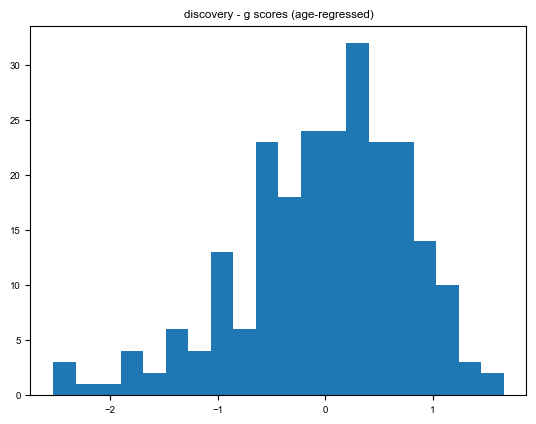

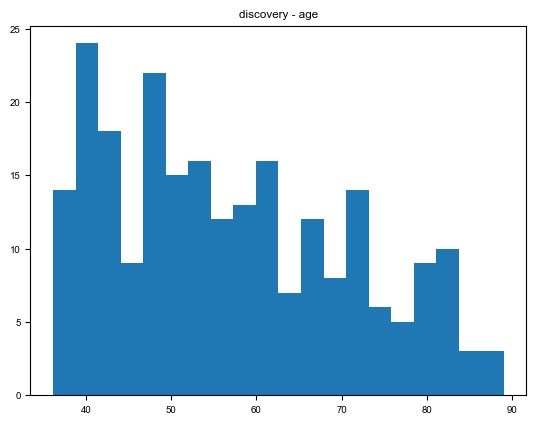

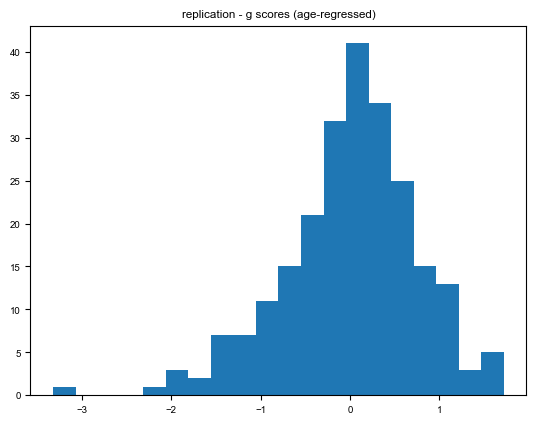

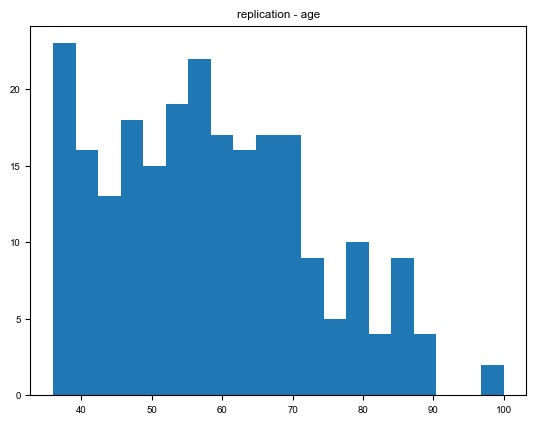

In [25]:
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV

gScoresAll = {}
subjAgeAll = {}

for dataset in ['discovery','replication']:
    scoresFile = f'{dataDir}/empirical/indivDiffs/gSubjScores_{dataset}.csv'

    print(dataset)
    gScoresDF = pd.read_csv(scoresFile,sep=',',index_col=0)
    gScores = gScoresDF.values.squeeze()

    subjectsDF = pd.read_csv(f'{scriptsDir}/subjects_{dataset}.tsv',sep='\t',index_col='subjects')
    subjAge = subjectsDF['age'].values
    
    print('g score-age correlation: ',stats.pearsonr(gScores,subjAge))
    
    reg = LinearRegression().fit(subjAge.reshape(-1, 1),gScores.reshape(-1, 1))
    print('intercept: ',reg.intercept_,'\tbeta: ',reg.coef_)
    gScoresAgeResid = gScores - reg.predict(subjAge.reshape(-1, 1)).squeeze()

    plt.figure()
    plt.hist(gScoresAgeResid,bins=20)
    plt.title(f'{dataset} - g scores (age-regressed)')
    
    plt.figure()
    plt.hist(subjAge,bins=20)
    plt.title(f'{dataset} - age')
    
    gScoresAll[dataset] = gScoresAgeResid
    subjAgeAll[dataset] = subjAge

In [26]:
def predictIndivDiffs(subjScores,fcVecs,kFolds=20,subjConfounds=None):
    
    FC = fcVecs.copy()
    nEdges = FC.shape[0]
    nSubjs = FC.shape[1]
    
    if not subjConfounds is None:
        if subjConfounds.ndim == 1:
            subjConfounds = subjConfounds[:,np.newaxis]
        for n in range(nEdges):
            regRemoveConfounds = LinearRegression().fit(np.hstack([subjConfounds,subjScores[:,np.newaxis]]),FC[n])
            FC[n] = FC[n] - np.sum(subjConfounds*regRemoveConfounds.coef_[:-1],axis=1)
            
    kFoldsSubjs = np.full((kFolds,nSubjs),False)    
    subjsPerFold = nSubjs//kFolds
    rem = nSubjs%kFolds
    s1 = 0
    for k in range(kFolds):
        s2 = s1+subjsPerFold
        if k < rem:
            s2 += 1
        kFoldsSubjs[k,s1:s2] = True
        s1 = s2
    
    subjsPerFold = nSubjs/kFolds
    s1 = 0
    for k in range(kFolds):
        s2 = int(np.round((k+1)*subjsPerFold))
        kFoldsSubjs[k,s1:s2] = True
        s1 = s2    
    
    k = 0
    for s in range(nSubjs):
        kFoldsSubjs[k,s] = True
        k += 1
        if k >= kFolds:
            k = 0

    predScores = np.zeros((nSubjs))
    betas = np.zeros((nEdges,kFolds))
    
    for k in range(kFolds):
        trainScores = subjScores[~kFoldsSubjs[k]].squeeze()
        
        trainFC = FC[:,~kFoldsSubjs[k]].squeeze()
        testFC = FC[:,kFoldsSubjs[k]]
        
        reg = RidgeCV().fit(trainFC.T,trainScores)
        predScores[kFoldsSubjs[k]] = reg.predict(testFC.T)
        betas[:,k] = reg.coef_
        
    return predScores,betas

In [27]:
predScoresAll = {'discovery':{1:{},2:{}},'replication':{1:{},2:{}}}
betasGScoresAll = {'discovery':{1:{},2:{}},'replication':{1:{},2:{}}}
predAgeAll = {'discovery':{1:{},2:{}},'replication':{1:{},2:{}}}
betasAgeAll = {'discovery':{1:{},2:{}},'replication':{1:{},2:{}}}

for dataset in ['discovery','replication']:
    for ses in [1]:
        print(f'{dataset} - {ses}')
        for method in methodsList:
            print(method)
            
            connFileFinal = f'{dataDir}/empirical/connectivity/{method}_{dataset}.h5'
            with h5py.File(connFileFinal,'r') as h5File:
                fcMats = h5File[f'ses-{ses}/FC'][:]
            fcVecs = fcMats[np.triu_indices(nNodes, k = 1)]
    
            predAgeAll[dataset][ses][method],betasAgeAll[dataset][ses][method] = predictIndivDiffs(subjAgeAll[dataset],fcVecs,kFolds=10)
            r,p = stats.pearsonr(subjAgeAll[dataset],predAgeAll[dataset][ses][method])
            print(f'\tage prediction - r = {r:.3f}, p {formatPVal(p)}')
            
            predScoresAll[dataset][ses][method],betasGScoresAll[dataset][ses][method] = predictIndivDiffs(gScoresAll[dataset],fcVecs,kFolds=10)
            r,p = stats.pearsonr(gScoresAll[dataset],predScoresAll[dataset][ses][method])
            print(f'\tg score prediction - r = {r:.3f}, p {formatPVal(p)}')
            print()
        

discovery - 1
pairwiseCorr
	age prediction - r = 0.739, p < .00001
	g score prediction - r = 0.309, p < .00001

partialCorr
	age prediction - r = 0.512, p < .00001
	g score prediction - r = 0.114, p = .079

graphicalLasso
	age prediction - r = 0.695, p < .00001
	g score prediction - r = 0.373, p < .00001

graphicalRidge
	age prediction - r = 0.702, p < .00001
	g score prediction - r = 0.404, p < .00001

pcRegression
	age prediction - r = 0.709, p < .00001
	g score prediction - r = 0.421, p < .00001

replication - 1
pairwiseCorr
	age prediction - r = 0.760, p < .00001
	g score prediction - r = 0.363, p < .00001

partialCorr
	age prediction - r = 0.579, p < .00001
	g score prediction - r = 0.113, p = .083

graphicalLasso
	age prediction - r = 0.737, p < .00001
	g score prediction - r = 0.402, p < .00001

graphicalRidge
	age prediction - r = 0.745, p < .00001
	g score prediction - r = 0.404, p < .00001

pcRegression
	age prediction - r = 0.754, p < .00001
	g score prediction - r = 0.415, 

[-3.32536222  1.72525364]
[ 36. 100.]


/tmp/ipykernel_12290/346143971.py:74: UserWarning: FixedFormatter should only be used together with FixedLocator
  cax.set_yticklabels(clabels,fontsize=7)
/tmp/ipykernel_12290/346143971.py:74: UserWarning: FixedFormatter should only be used together with FixedLocator
  cax.set_yticklabels(clabels,fontsize=7)


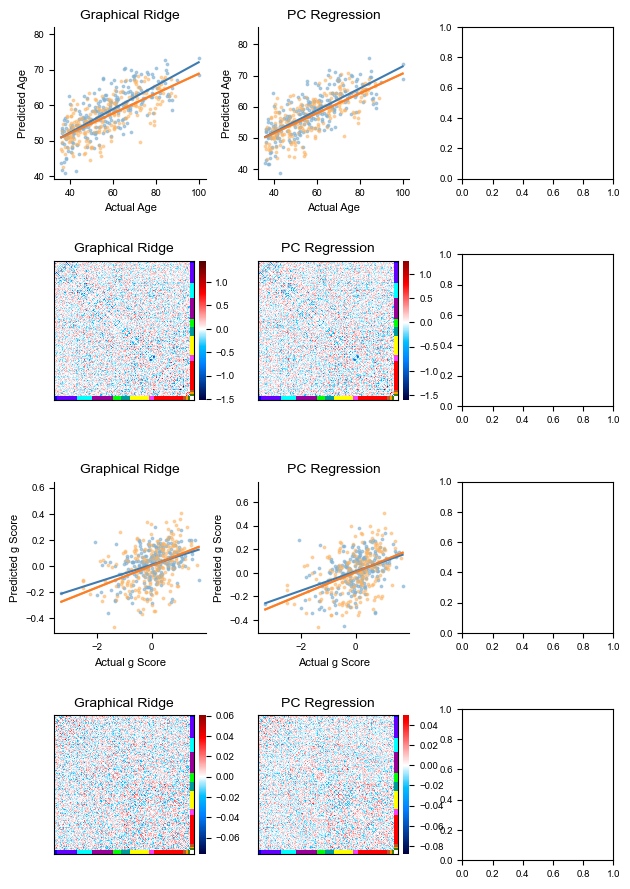

In [28]:
#methodsListFullnames = ['Pairwise Correlation','Partial Correlation','Graphical Lasso']
#methodsList_ = methodsList[0:3]
methodsListFullnames = ['Graphical Ridge','PC Regression']
methodsList_ = methodsList[3:]

palette = np.array(sns.color_palette("Set3"))
cols = [palette[5],palette[4]]

gScoresAllMinMax = np.array([np.min([gScoresAll['discovery'],gScoresAll['replication']]),np.max([gScoresAll['discovery'],gScoresAll['replication']])])
print(gScoresAllMinMax)
subjAgeAllMinMax = np.array([np.min([subjAgeAll['discovery'],subjAgeAll['replication']]),np.max([subjAgeAll['discovery'],subjAgeAll['replication']])])
print(subjAgeAllMinMax)

fig,axs = plt.subplots(4,3, figsize=(6.5,8.77),gridspec_kw={'hspace':.5,'wspace':.35},height_ratios=[1,1,1,1])#,sharey='row')
fig.subplots_adjust(left=.08,right=0.94,top=.96,bottom=.01)

for m,method in enumerate(methodsList_):
    
    axs[0,m].scatter(subjAgeAll['discovery'],predAgeAll['discovery'][1][method],3,color=cols[0],alpha=.3)
    axs[0,m].scatter(subjAgeAll['replication'],predAgeAll['replication'][1][method],3,color=cols[1],alpha=.6)
    axs[0,m].scatter(subjAgeAll['discovery'],predAgeAll['discovery'][1][method],3,color=cols[0],alpha=.3)
    
    discReg = LinearRegression().fit(subjAgeAll['discovery'].reshape(-1, 1),predAgeAll['discovery'][1][method].reshape(-1, 1))
    axs[0,m].plot(subjAgeAllMinMax,discReg.predict(subjAgeAllMinMax.reshape(-1,1)),color=(cols[0]*1)**2,alpha=1)
    repReg = LinearRegression().fit(subjAgeAll['replication'].reshape(-1, 1),predAgeAll['replication'][1][method].reshape(-1, 1))
    axs[0,m].plot(subjAgeAllMinMax,repReg.predict(subjAgeAllMinMax.reshape(-1,1)),color=(cols[1]*1)**2,alpha=1)
    axs[0,m].plot(subjAgeAllMinMax,discReg.predict(subjAgeAllMinMax.reshape(-1,1)),color=(cols[0]*1)**2,alpha=.8)
    
    axs[0,m].set_title(methodsListFullnames[m],fontsize=10)
    axs[0,m].set_ylabel('Predicted Age',fontsize=8)
    axs[0,m].set_xlabel('Actual Age',fontsize=8)
    axs[0,m].spines.right.set_visible(False)
    axs[0,m].spines.top.set_visible(False)
    ylims = axs[0,m].get_ylim()
    axs[0,m].set_ylim(ylims[0],ylims[1]+(ylims[1]-ylims[0])*.2)
    
    axs[2,m].scatter(gScoresAll['discovery'],predScoresAll['discovery'][1][method],3,color=cols[0],alpha=.3)
    axs[2,m].scatter(gScoresAll['replication'],predScoresAll['replication'][1][method],3,color=cols[1],alpha=.6)
    axs[2,m].scatter(gScoresAll['discovery'],predScoresAll['discovery'][1][method],3,color=cols[0],alpha=.3)
    
    discReg = LinearRegression().fit(gScoresAll['discovery'].reshape(-1, 1),predScoresAll['discovery'][1][method].reshape(-1, 1))
    axs[2,m].plot(gScoresAllMinMax,discReg.predict(gScoresAllMinMax.reshape(-1,1)),color=(cols[0]*1)**2)  
    repReg = LinearRegression().fit(gScoresAll['replication'].reshape(-1, 1),predScoresAll['replication'][1][method].reshape(-1, 1))
    axs[2,m].plot(gScoresAllMinMax,repReg.predict(gScoresAllMinMax.reshape(-1,1)),color=(cols[1]*1)**2)
    axs[2,m].plot(gScoresAllMinMax,discReg.predict(gScoresAllMinMax.reshape(-1,1)),color=(cols[0]*1)**2,alpha=.8)  
    
    axs[2,m].set_title(methodsListFullnames[m],fontsize=10)
    axs[2,m].set_ylabel('Predicted g Score',fontsize=8)
    axs[2,m].set_xlabel('Actual g Score',fontsize=8)
    axs[2,m].spines.right.set_visible(False)
    axs[2,m].spines.top.set_visible(False)
    ylims = axs[2,m].get_ylim()
    axs[2,m].set_ylim(ylims[0],ylims[1]+(ylims[1]-ylims[0])*.2)
    
    for a in [1,3]:
        if a==1:
            tmp = np.mean(np.hstack([betasAgeAll['discovery'][1][method],betasAgeAll['replication'][1][method]]),axis=1)
        else:
            tmp = np.mean(np.hstack([betasGScoresAll['discovery'][1][method],betasGScoresAll['replication'][1][method]]),axis=1)
    
        betasMat = np.zeros((nNodes,nNodes))
        betasMat[np.triu_indices(nNodes, k = 1)] = tmp
        betasMat = betasMat + betasMat.T
        
        axs[a,m],im = plotMatrix_cabnpNetColors(axs[a,m],betasMat,positions=['right','bottom'],buffer=10)
        axs[a,m].set_title(methodsListFullnames[m],fontsize=10)
        axs[a,m].set_xticks([]); axs[a,m].set_yticks([])
        
        divider = make_axes_locatable(axs[a,m])
        cax = divider.append_axes("right", size="5%", pad=0.05)
        cb = plt.colorbar(im,cax=cax)
        cb.outline.set_visible(False)
        clabels = cax.get_yticklabels()
        cax.set_yticklabels(clabels,fontsize=7)
        
if m==1:
    fig.savefig(f'{figDir}/figS9.pdf',dpi=900,transparent=True)
else:
    fig.savefig(f'{figDir}/fig9.pdf',dpi=900,transparent=True)


In [29]:
methodsPrintedLabels = ['Pairwise Correlation','Partial Correlation','Graphical Lasso','Graphical Ridge','PC Regression']
colNames = [(' ','Methods'),("Task Activity Prediction (Pearson's r)",'discovery'),("Task Activity Prediction (Pearson's r)","replication"),("Age Prediction (Pearson's r)",'discovery'),("Age Prediction (Pearson's r)","replication"),("Intelligence Prediction (Pearson's r)",'discovery'),("Intelligence Prediction (Pearson's r)",'replication')]

tableFilename = f'{figDir}/tableS_preds.tsv'
if os.path.exists(tableFilename):
    tableDF = pd.read_csv(tableFilename,sep='\t',index_col=0,header=[0,1])
else:
    tableDF = pd.DataFrame(columns=pd.MultiIndex.from_tuples(colNames, names=["line1", "line2"]))

ses = 1

for dataset in ['discovery','replication']:
    i = 1
    for m1,method1 in enumerate(methodsList):
        for m2,method2 in enumerate(methodsList):
            if m2 <= m1:
                continue
            tableDF.loc[i,(' ','Methods')] = f'{methodsPrintedLabels[m1]} vs. {methodsPrintedLabels[m2]}'
            
            corr1 = stats.pearsonr(subjAgeAll[dataset],predAgeAll[dataset][ses][method1])[0]
            corr2 = stats.pearsonr(subjAgeAll[dataset],predAgeAll[dataset][ses][method2])[0]
            corrBoth = stats.pearsonr(predAgeAll[dataset][ses][method1],predAgeAll[dataset][ses][method2])[0]
            diff = np.tanh(np.arctanh(corr1)-np.arctanh(corr2))
            Z,p = correlatedCorrelations(corr1,corr2,corrBoth,nSubjs)
            tableStr = f'∆r = {diff:.3f}, Z = {formatTStat(Z)}, p {formatPVal(p)}'
            tableDF.loc[i,("Age Prediction (Pearson's r)",dataset)] = tableStr
            
            corr1 = stats.pearsonr(gScoresAll[dataset],predScoresAll[dataset][ses][method1])[0]
            corr2 = stats.pearsonr(gScoresAll[dataset],predScoresAll[dataset][ses][method2])[0]
            corrBoth = stats.pearsonr(predScoresAll[dataset][ses][method1],predScoresAll[dataset][ses][method2])[0]
            diff = np.tanh(np.arctanh(corr1)-np.arctanh(corr2))
            Z,p = correlatedCorrelations(corr1,corr2,corrBoth,nSubjs)
            tableStr = f'∆r = {diff:.3f}, Z = {formatTStat(Z)}, p {formatPVal(p)}'
            tableDF.loc[i,("Intelligence Prediction (Pearson's r)",dataset)] = tableStr
            
            i+=1
        
print(tableDF)
tableDF.to_csv(tableFilename,sep='\t')


line1                                                \
line2                                       Methods   
1      Pairwise Correlation vs. Partial Correlation   
2          Pairwise Correlation vs. Graphical Lasso   
3          Pairwise Correlation vs. Graphical Ridge   
4            Pairwise Correlation vs. PC Regression   
5           Partial Correlation vs. Graphical Lasso   
6           Partial Correlation vs. Graphical Ridge   
7             Partial Correlation vs. PC Regression   
8               Graphical Lasso vs. Graphical Ridge   
9                 Graphical Lasso vs. PC Regression   
10                Graphical Ridge vs. PC Regression   

line1        Task Activity Prediction (Pearson's r)  \
line2                                     discovery   
1      mean ∆r = -0.081, T(235) = -16.4, p < .00001   
2      mean ∆r = -0.231, T(235) = -48.9, p < .00001   
3      mean ∆r = -0.206, T(235) = -46.1, p < .00001   
4      mean ∆r = -0.196, T(235) = -43.9, p < .00001   
5      me